# Cine segmentation
**CS 229**, spring 2019
**Author**: `Hui Xue <hui.xue@nih.gov>`

In [1]:
#import os
#os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
#os.environ['CUDA_VISIBLE_DEVICES']='1,2'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.onnx

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.utils import *

import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib import animation, rc
animation.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

import scipy
import scipy as sp
from scipy.spatial import ConvexHull
from scipy.ndimage.morphology import binary_fill_holes

from collections import OrderedDict
import time
from tensorboardX import SummaryWriter

from skimage import io, transform
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision

from IPython.display import display, clear_output, HTML, Image

from PIL import Image
import imp
import os
import sys
import math
import time
import random
import shutil
import scipy.misc
from glob import glob
import sklearn
import logging

%matplotlib inline
%load_ext autoreload
%autoreload 2

def show(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
#print(os.getcwd())
#os.mkdir('./DebugOutput')

def save_as_image(a, img_name='test', img_dir='./DebugOutput'):
    N, C, H, W = a.shape
    
    a = np.transpose(a, (2, 3, 1, 0))
    
    for n in range(N):
        filename = os.path.join(img_dir, img_name + str(n) + '.tif')
        if C==3:
            plt.imsave(filename, a[:,:,:,n])
            continue
        if C==1:
            plt.imsave(filename, a[:,:,0,n])
            continue
        pass

In [2]:
import torch.nn.functional as F

import training
import models
import utils
import utils.cmr_ml_utils_plotting

# dir(utils)

## Load image data

In [3]:
baseDir = '/mnt/Lab-Kellman/RawData/MachinLearning_Labelled_data/Cine/ForTraining'

In [6]:
img_dir = os.path.join(baseDir, 'set1_ready')
img_dir2 = os.path.join(baseDir, 'set2_ready')

In [7]:
import scipy.io

cases = os.listdir(img_dir)
images = []
for loc in cases:    
    images.extend(os.listdir(os.path.join(img_dir, loc)))  

num_cases = len(cases)
print("Found %d cases ... " % num_cases)

num_samples = len(images)
print("Found %d images ... " % num_samples)

print(cases[0:20])

Found 610 cases ... 
Found 14490 images ... 
['295', '662', '616', '111', '519', '443', '198', '480', '122', '529', '496', '283', '591', '147', '247', '486', '118', '516', '311', '325']


In [8]:
im = []
endo_mask = []
epi_mask = []
names = []

t0 = time.time()
print("Start loading samples ... ")

data_dir = os.path.join(img_dir, '86', 'I_05_00')

im = np.load(os.path.join(data_dir, 'im_train.npy'))
endo = np.load(os.path.join(data_dir, 'endo_train.npy'))
epi = np.load(os.path.join(data_dir, 'epi_train.npy'))

t1 = time.time()
print('loading took %f ' % (t1-t0))

Start loading samples ... 
loading took 0.047485 


float64
(380, 276)
(380, 276)
(380, 276)
380 276


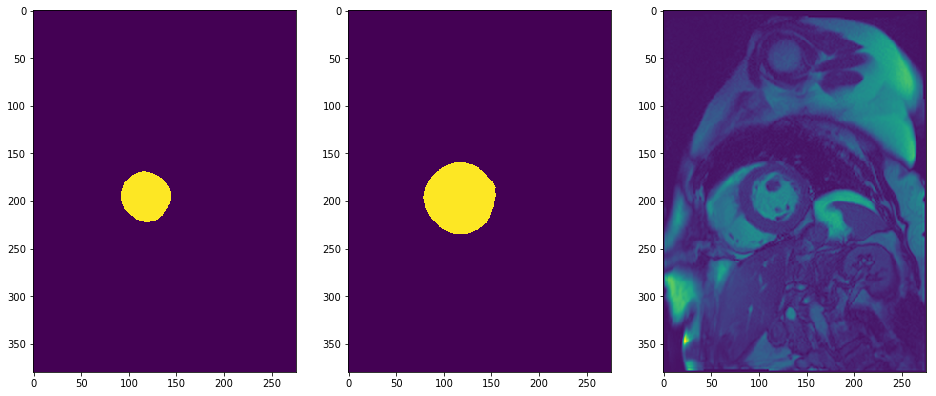

In [9]:

print(im.dtype)
print(im.shape)

print(endo.shape)
print(epi.shape)

RO, E1 = im.shape
print(RO, E1)

num = 3
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,num, 1)
ax.imshow(endo)
ax = fig.add_subplot(1,num, 2)
ax.imshow(epi)
ax = fig.add_subplot(1,num, 3)
ax.imshow(im)
    

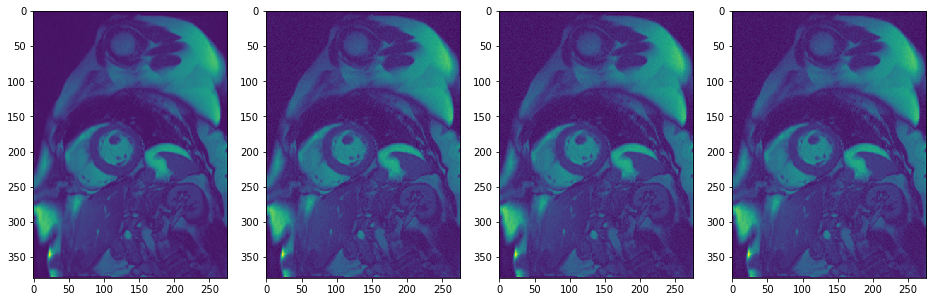

In [17]:
m_im = np.mean(im)

s1 = np.random.normal(0, 0.1*m_im, im.shape)
im_n1 = im + s

s2 = np.random.normal(0, 0.2*m_im, im.shape)
im_n2 = im + s

s3 = np.random.normal(0, 0.3*m_im, im.shape)
im_n3 = im + s

num = 4
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1,num, 1)
ax.imshow(im)
ax = fig.add_subplot(1,num, 2)
ax.imshow(im_n1)
ax = fig.add_subplot(1,num, 3)
ax.imshow(im_n2)
ax = fig.add_subplot(1,num, 4)
ax.imshow(im_n3)

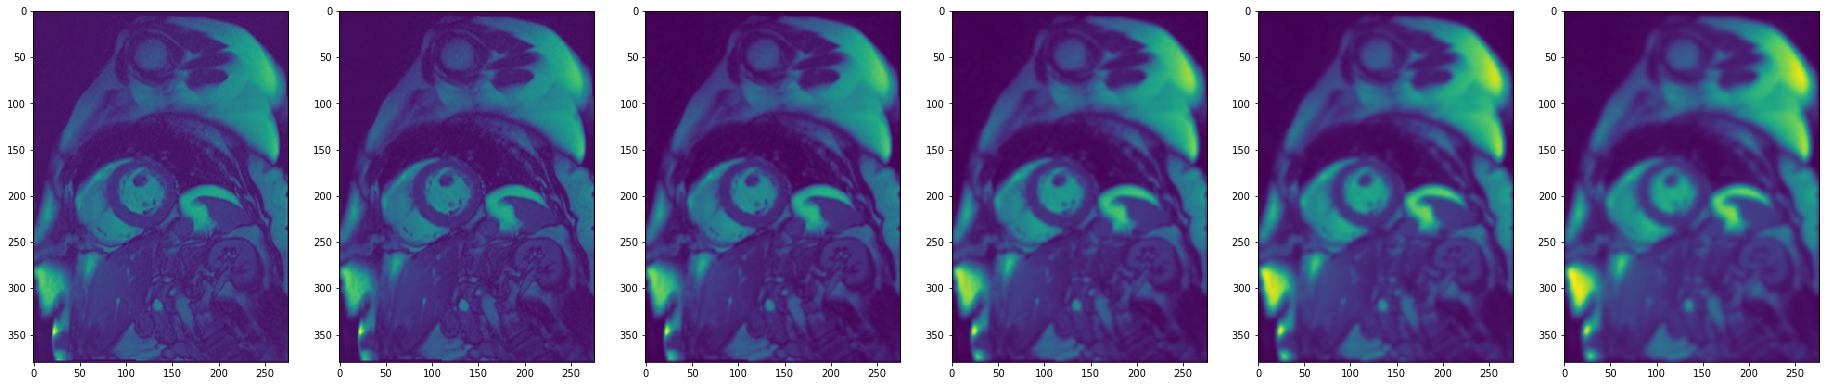

In [11]:
im_fil1 = scipy.ndimage.gaussian_filter(im, sigma=0.5, mode='constant')
im_fil2 = scipy.ndimage.gaussian_filter(im, sigma=1, mode='constant')
im_fil3 = scipy.ndimage.gaussian_filter(im, sigma=1.5, mode='constant')
im_fil4 = scipy.ndimage.gaussian_filter(im, sigma=2.0, mode='constant')
im_fil5 = scipy.ndimage.gaussian_filter(im, sigma=2.5, mode='constant')

num = 6
fig = plt.figure(figsize=(32, 24))
ax = fig.add_subplot(1,num, 1)
ax.imshow(im)
ax = fig.add_subplot(1,num, 2)
ax.imshow(im_fil1)
ax = fig.add_subplot(1,num, 3)
ax.imshow(im_fil2)
ax = fig.add_subplot(1,num, 4)
ax.imshow(im_fil3)
ax = fig.add_subplot(1,num, 5)
ax.imshow(im_fil4)
ax = fig.add_subplot(1,num, 6)
ax.imshow(im_fil5)

## Data augmentation

In [32]:
class RandomAddNoise(object):
    """Randomly add white noise to image.
    Args:
        p (float): probability to add noise. Default value is 0.5
    """

    def __init__(self, p=0.5, sigma=[0.05, 0.075, 0.1, 0.15, 0.2, 0.3]):
        self.p = p        
        self.sigma = sigma
        

    def __call__(self, img):
        """
        Args:
            img ([N RO E1 ... ]): Image to be flipped.
        Returns:
            res: Randomly blurred image.
        """
        #print(img[0].shape)
        #print(img[1].shape)
            
        if random.random() < self.p: 
                                
            a = np.transpose(img[0], [1, 2, 0])

            # pick a sigma
            ind = np.random.random_integers(0, len(self.sigma)-1)
            sigma = self.sigma[ind]
            
            RO, E1, N = a.shape
            
            for n in range(N):
                im = a[:,:,n]
                m_im = np.mean(im)
                s = np.random.normal(0, sigma*m_im, (RO, E1))
                im = im + s
                im = im / np.max(im)
                a[:, :, n] = im
                
            a = np.transpose(a, [2, 0, 1])            
            
            return ( a.copy(), img[1], img[2] )
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)
    
class RandomBlurring(object):
    """Randomly blurring the numpy array using Gaussian filter.
    Args:
        p (float): probability of the image being blurred. Default value is 0.5
    """

    def __init__(self, p=0.5, sigma=[0.5, 0.75, 1.0, 1.25, 1.5]):
        self.p = p        
        self.sigma = sigma
        

    def __call__(self, img):
        """
        Args:
            img ([N RO E1 ... ]): Image to be flipped.
        Returns:
            res: Randomly blurred image.
        """
        #print(img[0].shape)
        #print(img[1].shape)
            
        if random.random() < self.p: 
                                
            a = np.transpose(img[0], [1, 2, 0])

            # pick a sigma
            ind = np.random.random_integers(0, len(self.sigma)-1)
            sigma = self.sigma[ind]
            
            RO, E1, N = a.shape
            
            for n in range(N):
                im = a[:,:,n]
                im_fil = scipy.ndimage.gaussian_filter(im, sigma=sigma, mode='constant')
                im_fil = im_fil / np.max(im_fil)
                a[:,:,n] = im_fil
            
            a = np.transpose(a, [2, 0, 1])
            
            return ( a.copy(), img[1], img[2] )
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)
    
class RandomFlip1stDim(object):
    """Randomly flip the first dimension of numpy array.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img ([N RO E1 ... ]): Image to be flipped.
        Returns:
            res: Randomly flipped image.
        """
        #print(img[0].shape)
        #print(img[1].shape)
            
        if random.random() < self.p: 
                                
            a = np.transpose(img[0], [1, 2, 0])
            a = np.flipud(a)
            a = np.transpose(a, [2, 0, 1])
            
            b = np.transpose(img[1], [1, 2, 0])
            b = np.flipud(b)
            b = np.transpose(b, [2, 0, 1])
            return ( a.copy(), b.copy(), img[2] )
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)
    
class RandomFlip2ndDim(object):
    """Randomly flip the second dimension of numpy array.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img ([N RO E1 ... ]): Image to be flipped.
        Returns:
            res: Randomly flipped image.
        """
        if random.random() < self.p:    
            a = np.transpose(img[0], [1, 2, 0])
            a = np.fliplr(a)
            a = np.transpose(a, [2, 0, 1])
            
            b = np.transpose(img[1], [1, 2, 0])
            b = np.fliplr(b)
            b = np.transpose(b, [2, 0, 1])
            return ( a.copy(), b.copy(), img[2] )
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)
    
class RandomPermute2DT(object):
    """Randomly permute 1st and 2nd dimensions of numpy array.
    Args:
        p (float): probability of the image being permuted. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img ([N RO E1 ... ]): Image to be flipped.
        Returns:
            res: Randomly flipped image.
        """
        if random.random() < self.p:            
            return ( np.transpose(img[0], (0, 2, 1)).copy(), np.transpose(img[1], (0, 2, 1)).copy(), img[2] )
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)    
    
class RandomCrop2D(object):
    """Randomly crop the numpy array, for 2D.
    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """
    def __init__(self, dst_ro, dst_e1, p=0.5, ro_range=(-24, 24), e1_range=(-24, 24)):
        self.p = p
        self.ro_range = ro_range
        self.e1_range = e1_range
        self.dst_ro = dst_ro
        self.dst_e1 = dst_e1

    def __call__(self, img):
        """
        Args:
            img ([Ro E1 N ... ]): Image to be cropped.
        Returns:
            res: Randomly cropped image.
        """
        
        N, RO, E1 = img[0].shape

        ps_x = int(RO/2 - self.dst_ro/2)
        pe_x = ps_x + self.dst_ro
        ps_y = int(E1/2 - self.dst_e1/2)
        pe_y = ps_y + self.dst_e1
        
        if random.random() < self.p:                                   
            ro_shifts = np.random.randint(self.ro_range[0], self.ro_range[1]+1, 1)
            e1_shifts = np.random.randint(self.e1_range[0], self.e1_range[1]+1, 1)
            ro_shifts = ro_shifts[0]
            e1_shifts = e1_shifts[0]
        else:
            ro_shifts = 0
            e1_shifts = 0
            
        ss_ps_x = ps_x + ro_shifts
        ss_ps_y = ps_y + e1_shifts

        ss_pe_x = pe_x + ro_shifts
        ss_pe_y = pe_y + e1_shifts

        if(ss_ps_x<0 or ss_pe_x>=RO):
            ss_ps_x = ps_x
            ss_pe_x = pe_x

        if(ss_ps_y<0 or ss_pe_y>=E1):
            ss_ps_y = ps_y
            ss_pe_y = pe_y

        #print(img[0].shape)
        #print(ss_ps_x, ss_pe_x)
        #print(ss_ps_y, ss_pe_y)
            
        a = img[0][:, ss_ps_x:ss_pe_x, ss_ps_y:ss_pe_y]
        a = a / np.max(a)
        
        b = np.expand_dims(img[1][0, ss_ps_x:ss_pe_x, ss_ps_y:ss_pe_y], axis=0)                                

        return ( a, b, img[2] )
        
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)

## Load data and apply random crop

In [13]:
class CineDatasetRandomCrop(Dataset):
    """Perfusion dataset."""

    def __init__(self, img_dirs, which_mask='endo', num_of_random=9, transform=None, data_size=(216, 216)):
        """
        Args:
            img_dirs (list of strings): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            if num_of_random<=0, no crop was performed
        """
        self.img_dirs = img_dirs
        self.transform = transform
        self.which_mask = which_mask # endo or epi
        self.num_of_random = num_of_random
        self.data_size = data_size
        
        self.ro_range = (-36, 36)
        self.e1_range = (-36, 36)
        
        # find all images
        for img_dir in self.img_dirs:
            locations = os.listdir(img_dir)
            a = []
            for loc in locations:
                a.extend(os.listdir(os.path.join(img_dir, loc)))

        num_samples = len(a)
        print("Found %d cases in all folders ... \n" % num_samples)
        
        self.im = []
        self.endo_masks = []
        self.names = []
        
        self.im_for_epi = []
        self.epi_masks = []
        self.names_epi = []

        for img_dir in self.img_dirs:
            self.load(img_dir)
        
                                            
    def load(self, img_dir):
        
        locations = os.listdir(img_dir)
        
        a = []
        for loc in locations:
            a.extend(os.listdir(os.path.join(img_dir, loc)))

        num_samples = len(a)
        
        t0 = time.time()
        print("=============> Start loading cases for ", img_dir, "<==============================")
        
        total_case_loaded = 0
        total_num_loaded = 0
        
        for loc in locations:
            
            #if (total_case_loaded>100):
            #        break
                    
            a = os.listdir(os.path.join(img_dir, loc))
            print('--------------------------> Start loading ', loc, ' <--------------------------')
            print(a)
            for ii, n in enumerate(a):                                      
                
                if(ii==0):
                    print('------> Start loading %d out of %d, %s - %s' % (total_case_loaded, num_samples, loc, n))
                    
                name = os.path.join(loc, n)                
                
                im = np.load(os.path.join(img_dir, name, 'im_train.npy'))
                endo = np.load(os.path.join(img_dir, name, 'endo_train.npy'))
                
                #max_endo = np.max(endo)
                #if(max_endo==0):
                #    print('IGNORE, max endo = 0, %s - %s' % (loc, n))
                #    continue
                
                epi_file = os.path.join(img_dir, name, 'epi_train.npy')
                exists = os.path.isfile(epi_file)
                if(exists):
                    epi = np.load(epi_file)
                                    
                RO, E1 = im.shape

                # if image size is too small, padding it
                if(RO<self.data_size[0]):
                    
                    print("data size ", im.shape)
                    
                    im_new = np.zeros((self.data_size[0], E1), dtype=im.dtype)
                    s_ro = round(self.data_size[0]/2 - RO/2)
                    if(s_ro<0):
                        s_ro = 0
                    
                    im_new[s_ro:s_ro+RO, :] = im                    
                    im = im_new
                    
                    endo_new = np.zeros((self.data_size[0], E1), dtype=endo.dtype)
                    endo_new[s_ro:s_ro+RO, :] = endo                    
                    endo = endo_new
                    
                    if(exists):
                        epi_new = np.zeros((self.data_size[0], E1), dtype=endo.dtype)
                        epi_new[s_ro:s_ro+RO, :] = epi                    
                        epi = epi_new
                        
                
                RO = im.shape[0]
                
                if(E1<self.data_size[1]):
                    
                    print("data size ", im.shape)
                    
                    im_new = np.zeros((RO, self.data_size[1]), dtype=im.dtype)
                    s_e1 = round(self.data_size[1]/2 - E1/2)
                    if(s_e1<0):
                        s_e1 = 0
                    
                    im_new[:, s_e1:s_e1+E1] = im                    
                    im = im_new
                           
                    endo_new = np.zeros((RO, self.data_size[1]), dtype=endo.dtype)
                    endo_new[:, s_e1:s_e1+E1] = endo                    
                    endo = endo_new
                    
                    if(exists):
                        epi_new = np.zeros((RO, self.data_size[1]), dtype=endo.dtype)
                        epi_new[:, s_e1:s_e1+E1] = epi                    
                        epi = epi_new
                    
                RO, E1 = im.shape
                           
                if(self.num_of_random>0):
                    ro_shifts = np.random.randint(self.ro_range[0], self.ro_range[1]+1, self.num_of_random)
                    e1_shifts = np.random.randint(self.e1_range[0], self.e1_range[1]+1, self.num_of_random)

                    ps_x = round(RO/2 - self.data_size[0]/2)
                    if(ps_x<0):
                        ps_x = 0

                    pe_x = ps_x + self.data_size[0]

                    ps_y = round(E1/2 - self.data_size[1]/2)
                    if(ps_y<0):
                        ps_y = 0

                    pe_y = ps_y + self.data_size[1]

                    if (ii == 0):
                        print('    image size [%d, %d], ro, [start, end] = %d, %d; e1, [start, end] = %d, %d' % (RO, E1, ps_x, pe_x, ps_y, pe_y))

                    # random crop
                    for rc in np.arange(self.num_of_random):

                        if(rc==0):
                            ss_ps_x = ps_x;
                            ss_ps_y = ps_y;

                            ss_pe_x = pe_x;
                            ss_pe_y = pe_y;
                        else:
                            ss_ps_x = ps_x + ro_shifts[rc-1];
                            ss_ps_y = ps_y + e1_shifts[rc-1];

                            ss_pe_x = pe_x + ro_shifts[rc-1];
                            ss_pe_y = pe_y + e1_shifts[rc-1];

                        if(ss_ps_x<0 or ss_ps_y<0):
                            continue;

                        if(ss_pe_x>RO and ss_pe_y>E1):
                            continue;


                        im_s = im[ss_ps_x:ss_pe_x, ss_ps_y:ss_pe_y]
                        endo_s = endo[ss_ps_x:ss_pe_x, ss_ps_y:ss_pe_y]

                        if(exists):
                            epi_s = epi[ss_ps_x:ss_pe_x, ss_ps_y:ss_pe_y]

                        im_s = im_s / np.max(im_s)

                        if(im_s.shape[0] != self.data_size[0]):
                            continue;
                        if(im_s.shape[1] != self.data_size[1]):
                            continue;

                        im_s = np.expand_dims(im_s, axis=0)
                        endo_s = np.expand_dims(endo_s, axis=0)

                        if(exists):
                            epi_s = np.expand_dims(epi_s, axis=0)

                        self.im.append(im_s)
                        self.endo_masks.append(endo_s)

                        if(exists):
                            self.im_for_epi.append(im_s)
                            self.epi_masks.append(epi_s)
                            self.names_epi.append(name + '_' + str(rc))

                        self.names.append(name + '_' + str(rc))
                else:
                    self.im.append(np.expand_dims(im, axis=0))
                    self.endo_masks.append(np.expand_dims(endo, axis=0))
                    self.names.append(name)

                    if(exists):
                        self.im_for_epi.append(np.expand_dims(im, axis=0))
                        self.epi_masks.append(np.expand_dims(epi, axis=0))
                        self.names_epi.append(name)
                
                total_case_loaded += 1
                
                if(self.num_of_random>0):
                    total_num_loaded += (self.num_of_random+1)
                else:
                    total_num_loaded += 1
                
            t1 = time.time()
            print("             Time from starting : %f seconds ... \n" % (t1-t0))
        
    def __len__(self):
        
        if (self.which_mask == 'endo'):
            return len(self.im)
        
        if (self.which_mask == 'epi'):
            return len(self.im_for_epi)

    def __getitem__(self, idx):
        
        if idx >= len(self.im):
            raise "invalid index"
                   
        if (self.which_mask == 'endo'):            
            sample = (self.im[idx], self.endo_masks[idx], self.names[idx])
            
        if (self.which_mask == 'epi'):
            sample = (self.im_for_epi[idx], self.epi_masks[idx], self.names_epi[idx])
            
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    
    def __str__(self):
        str = "Cine Dataset\n"        
        
        for img_dir in self.img_dirs:            
            str += "  image root: %s" % img_dir + "\n"
            
        str += "  mask: %s" % self.which_mask + "\n"
        
        str += "  Number of samples: %d" % len(self.im) + "\n"
        str += "  Number of endo masks: %d" % len(self.endo_masks) + "\n"
        if len(self.im) > 0:
            str += "  endo image shape: %d %d %d" % self.im[0].shape + "\n"
            str += "  endo mask shape: %d %d %d" % self.endo_masks[0].shape + "\n"

        str += "  Number of image for epi samples: %d" % len(self.im_for_epi) + "\n"
        str += "  Number of epi masks: %d" % len(self.epi_masks) + "\n"
        if len(self.im_for_epi) > 0:
            str += "  epi image shape: %d %d %d" % self.im_for_epi[0].shape + "\n"
            str += "  epi mask shape: %d %d %d" % self.epi_masks[0].shape + "\n"
                
        return str

In [14]:
num_of_random = 16

cine_dataset = CineDatasetRandomCrop([img_dir, img_dir2], num_of_random=num_of_random)
print("Done")

Found 13594 cases in all folders ... 

=============> Start loading cases for  /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set1_ready <==============================
--------------------------> Start loading  295  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_15_00', 'I_05_00']
------> Start loading 0 out of 14490, 295 - I_04_01
    image size [320, 260], ro, [start, end] = 52, 268; e1, [start, end] = 22, 238
             Time from starting : 0.867387 seconds ... 

--------------------------> Start loading  662  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_

             Time from starting : 15.773814 seconds ... 

--------------------------> Start loading  486  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 384 out of 14490, 486 - I_04_01
    image size [360, 360], ro, [start, end] = 72, 288; e1, [start, end] = 72, 288
             Time from starting : 16.877960 seconds ... 

--------------------------> Start loading  118  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 

             Time from starting : 30.494982 seconds ... 

--------------------------> Start loading  596  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 776 out of 14490, 596 - I_04_01
    image size [380, 309], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 31.613778 seconds ... 

--------------------------> Start loading  164  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 804 out of 14490, 164 

             Time from starting : 43.576448 seconds ... 

--------------------------> Start loading  402  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1132 out of 14490, 402 - I_04_01
    image size [320, 320], ro, [start, end] = 52, 268; e1, [start, end] = 52, 268
             Time from starting : 44.406862 seconds ... 

--------------------------> Start loading  166  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1156 out of 14490, 166 - I_04_01
    image size [400, 313], ro, [start, end] = 92, 308;

             Time from starting : 58.269071 seconds ... 

--------------------------> Start loading  475  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1516 out of 14490, 475 - I_04_01
    image size [340, 340], ro, [start, end] = 62, 278; e1, [start, end] = 62, 278
             Time from starting : 59.192382 seconds ... 

--------------------------> Start loading  530  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1540 out of 14490, 530 - I_04_01
    image 

             Time from starting : 72.861452 seconds ... 

--------------------------> Start loading  477  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1894 out of 14490, 477 - I_04_01
    image size [340, 340], ro, [start, end] = 62, 278; e1, [start, end] = 62, 278
             Time from starting : 73.870822 seconds ... 

--------------------------> Start loading  492  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading

             Time from starting : 86.843068 seconds ... 

--------------------------> Start loading  517  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2264 out of 14490, 517 - I_04_01
    image size [400, 400], ro, [start, end] = 92, 308; e1, [start, end] = 92, 308
             Time from starting : 88.035724 seconds ... 

--------------------------> Start loading  485  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2290 out of 14490, 485 - I_04_01
    image size [440, 440], ro, [

             Time from starting : 100.165268 seconds ... 

--------------------------> Start loading  209  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2638 out of 14490, 209 - I_04_01
    image size [380, 273], ro, [start, end] = 82, 298; e1, [start, end] = 28, 244
             Time from starting : 100.847602 seconds ... 

--------------------------> Start loading  41  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2658 out of 14490, 41 - I_04_01
data size  (300, 206)
    image size [300, 216], ro, [start, end] = 42, 258; e1, [start, end] = 0,

             Time from starting : 113.542797 seconds ... 

--------------------------> Start loading  439  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2994 out of 14490, 439 - I_04_01
    image size [380, 380], ro, [start, end] = 82, 298; e1, [start, end] = 82, 298
             Time from starting : 114.570365 seconds ... 

--------------------------> Start loading  242  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3018 out of 14490, 242 - I_04_01
    image size [320, 260], ro, [start, end] = 52, 268; e1, [start, end] = 

             Time from starting : 128.514608 seconds ... 

--------------------------> Start loading  431  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3352 out of 14490, 431 - I_04_01
    image size [400, 400], ro, [start, end] = 92, 308; e1, [start, end] = 92, 308
             Time from starting : 129.805582 seconds ... 

--------------------------> Start loading  611  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3380 out of 14490, 

             Time from starting : 143.199561 seconds ... 

--------------------------> Start loading  220  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3728 out of 14490, 220 - I_04_01
    image size [344, 344], ro, [start, end] = 64, 280; e1, [start, end] = 64, 280
             Time from starting : 144.217625 seconds ... 

--------------------------> Start loading  594  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3754 out of 14490, 594 - I_04_01
    image size [360, 270], ro,

             Time from starting : 157.827984 seconds ... 

--------------------------> Start loading  121  <--------------------------
['I_17_00', 'I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_17_01', 'I_11_01', 'I_16_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_16_00', 'I_15_00', 'I_05_00']
------> Start loading 4106 out of 14490, 121 - I_17_00
    image size [300, 244], ro, [start, end] = 42, 258; e1, [start, end] = 14, 230
             Time from starting : 158.728155 seconds ... 

--------------------------> Start loading  333  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00

             Time from starting : 172.093835 seconds ... 

--------------------------> Start loading  392  <--------------------------
['I_17_00', 'I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_17_01', 'I_11_01', 'I_16_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_16_00', 'I_15_00', 'I_05_00']
------> Start loading 4484 out of 14490, 392 - I_17_00
    image size [380, 333], ro, [start, end] = 82, 298; e1, [start, end] = 58, 274
             Time from starting : 173.617631 seconds ... 

--------------------------> Start loading  382  <--------------------------
['I_17_00', 'I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01

             Time from starting : 185.816009 seconds ... 

--------------------------> Start loading  502  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4858 out of 14490, 502 - I_04_01
    image size [380, 380], ro, [start, end] = 82, 298; e1, [start, end] = 82, 298
             Time from starting : 186.867199 seconds ... 

--------------------------> Start loading  44  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4882 out of 14490, 44 - I_04_01
    image size [270, 360], ro, [start, end] = 27, 243; e1, [start, end] = 72

             Time from starting : 199.323874 seconds ... 

--------------------------> Start loading  655  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5242 out of 14490, 655 - I_04_01
    image size [270, 360], ro, [start, end] = 27, 243; e1, [start, end] = 72, 288
             Time from starting : 199.965503 seconds ... 

--------------------------> Start loading  59  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5262 out of 14490, 59 - I_04_01
    image size [440, 330], ro, [start, end] = 112, 328; e1, [start, end] = 5

             Time from starting : 214.205132 seconds ... 

--------------------------> Start loading  197  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5618 out of 14490, 197 - I_04_01
    image size [380, 309], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 215.063926 seconds ... 

--------------------------> Start loading  302  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5640 out of 14490, 302 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 30

             Time from starting : 228.274539 seconds ... 

--------------------------> Start loading  555  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6000 out of 14490, 555 - I_04_01
    image size [350, 350], ro, [start, end] = 67, 283; e1, [start, end] = 67, 283
             Time from starting : 229.255150 seconds ... 

--------------------------> Start loading  200  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6024 out of 14490, 200 - I_04_01
    image size [360, 236], ro, [start, end] = 72, 288; e1, [start, end] = 10, 226
             T

             Time from starting : 241.093361 seconds ... 

--------------------------> Start loading  599  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6356 out of 14490, 599 - I_04_01
    image size [370, 254], ro, [start, end] = 77, 293; e1, [start, end] = 19, 235
             Time from starting : 241.686646 seconds ... 

--------------------------> Start loading  395  <--------------------------
['I_17_00', 'I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_17_01', 'I_11_01', 'I_16_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_16_00

             Time from starting : 254.572397 seconds ... 

--------------------------> Start loading  546  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6726 out of 14490, 546 - I_04_01
    image size [360, 360], ro, [start, end] = 72, 288; e1, [start, end] = 72, 288
             Time from starting : 255.591375 seconds ... 

--------------------------> Start loading  196  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6750 out of 14490, 

             Time from starting : 270.710691 seconds ... 

--------------------------> Start loading  609  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7130 out of 14490, 609 - I_04_01
    image size [380, 309], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 271.676953 seconds ... 

--------------------------> Start loading  139  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7154 out of 14490, 139 - I_04_01
    image size [330, 268], ro, [start, end] = 57, 27

             Time from starting : 284.555288 seconds ... 

--------------------------> Start loading  456  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7498 out of 14490, 456 - I_04_01
    image size [340, 340], ro, [start, end] = 62, 278; e1, [start, end] = 62, 278
             Time from starting : 285.473201 seconds ... 

--------------------------> Start loading  575  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7522 out of 14490, 575 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 30

             Time from starting : 297.609590 seconds ... 

--------------------------> Start loading  4  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7864 out of 14490, 4 - I_04_01
    image size [380, 321], ro, [start, end] = 82, 298; e1, [start, end] = 52, 268
             Time from starting : 298.609837 seconds ... 

--------------------------> Start loading  74  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7888 out of 14490, 74 - I_04_01
    image size [350, 263], ro, [start, end] = 67, 283; e1,

             Time from starting : 311.899865 seconds ... 

--------------------------> Start loading  344  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8240 out of 14490, 344 - I_04_01
    image size [360, 248], ro, [start, end] = 72, 288; e1, [start, end] = 16, 232
             Time from starting : 312.508066 seconds ... 

--------------------------> Start loading  411  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8262 out of 14490, 411 - I_04_01
    image size [340, 340], ro,

             Time from starting : 324.530597 seconds ... 

--------------------------> Start loading  228  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8588 out of 14490, 228 - I_04_01
    image size [350, 284], ro, [start, end] = 67, 283; e1, [start, end] = 34, 250
             Time from starting : 325.184804 seconds ... 

--------------------------> Start loading  513  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8608 out of 14490, 513 - I_04_01
    image size [340, 340], ro,

             Time from starting : 338.184895 seconds ... 

--------------------------> Start loading  10  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8962 out of 14490, 10 - I_04_01
    image size [321, 380], ro, [start, end] = 52, 268; e1, [start, end] = 82, 298
             Time from starting : 339.153867 seconds ... 

--------------------------> Start loading  408  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8986 out of 14490, 408 - I_04_01
    image size [340, 340], ro, [

             Time from starting : 354.109581 seconds ... 

--------------------------> Start loading  218  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9354 out of 14490, 218 - I_04_01
    image size [360, 293], ro, [start, end] = 72, 288; e1, [start, end] = 38, 254
             Time from starting : 354.671926 seconds ... 

--------------------------> Start loading  656  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9370 out of 14490, 656 - I_04_01
    image size [400, 350], ro, [start, end] = 92, 308; e1, [start, end] = 67, 283
             Time from starting : 355.555160 seconds ... 


             Time from starting : 368.018865 seconds ... 

--------------------------> Start loading  285  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9716 out of 14490, 285 - I_04_01
    image size [380, 309], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 368.962341 seconds ... 

--------------------------> Start loading  20  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00'

             Time from starting : 383.174521 seconds ... 

--------------------------> Start loading  353  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10102 out of 14490, 353 - I_04_01
    image size [340, 340], ro, [start, end] = 62, 278; e1, [start, end] = 62, 278
             Time from starting : 384.098691 seconds ... 

--------------------------> Start loading  552  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start load

             Time from starting : 398.275243 seconds ... 

--------------------------> Start loading  65  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10492 out of 14490, 65 - I_04_01
    image size [350, 263], ro, [start, end] = 67, 283; e1, [start, end] = 24, 240
             Time from starting : 398.747611 seconds ... 

--------------------------> Start loading  313  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10508 out of 14490, 313 - I_04_01
    image size [350, 263], ro, [start, end] = 67, 283; e1, [start, end] = 24, 240
             Time from starting : 399.321540 seconds ... 


             Time from starting : 412.148742 seconds ... 

--------------------------> Start loading  322  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10868 out of 14490, 322 - I_04_01
    image size [340, 234], ro, [start, end] = 62, 278; e1, [start, end] = 9, 225
             Time from starting : 412.736602 seconds ... 

--------------------------> Start loading  27  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00'

             Time from starting : 429.419019 seconds ... 

--------------------------> Start loading  376  <--------------------------
['I_17_00', 'I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_18_01', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_17_01', 'I_11_01', 'I_16_01', 'I_18_00', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_16_00', 'I_15_00', 'I_05_00']
------> Start loading 11274 out of 14490, 376 - I_17_00
    image size [340, 298], ro, [start, end] = 62, 278; e1, [start, end] = 41, 257
             Time from starting : 430.695294 seconds ... 

--------------------------> Start loading  633  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_0

             Time from starting : 443.662624 seconds ... 

--------------------------> Start loading  43  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11668 out of 14490, 43 - I_04_01
    image size [400, 362], ro, [start, end] = 92, 308; e1, [start, end] = 73, 289
             Time from starting : 444.492213 seconds ... 

--------------------------> Start loading  40  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11688 out of 14490, 40 - I_04_01
    image size [360, 248], ro, [

             Time from starting : 457.509305 seconds ... 

--------------------------> Start loading  515  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12042 out of 14490, 515 - I_04_01
    image size [400, 400], ro, [start, end] = 92, 308; e1, [start, end] = 92, 308
             Time from starting : 458.788423 seconds ... 

--------------------------> Start loading  315  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12070 out of 14490

             Time from starting : 470.805373 seconds ... 

--------------------------> Start loading  419  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12412 out of 14490, 419 - I_04_01
    image size [360, 360], ro, [start, end] = 72, 288; e1, [start, end] = 72, 288
             Time from starting : 471.818050 seconds ... 

--------------------------> Start loading  556  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12436 out of 14490, 556 - I_04_01
    image size [360, 360], r

             Time from starting : 483.553791 seconds ... 

--------------------------> Start loading  145  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12764 out of 14490, 145 - I_04_01
    image size [370, 324], ro, [start, end] = 77, 293; e1, [start, end] = 54, 270
             Time from starting : 484.440805 seconds ... 

--------------------------> Start loading  282  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12786 out of 14490, 282 - I_04_01
    image size [360, 293], ro, [start, end] = 72, 

             Time from starting : 497.064222 seconds ... 

--------------------------> Start loading  260  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13146 out of 14490, 260 - I_04_01
    image size [309, 450], ro, [start, end] = 46, 262; e1, [start, end] = 117, 333
             Time from starting : 497.926095 seconds ... 

--------------------------> Start loading  627  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13166 out of 14490, 627 - I_04_01
    image size [320, 220], ro, [start, end] = 52, 268; e1, [start, end] = 2, 218
            

             Time from starting : 509.702425 seconds ... 

--------------------------> Start loading  264  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13504 out of 14490, 264 - I_04_01
    image size [380, 309], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 510.560293 seconds ... 

--------------------------> Start loading  19  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loadi

             Time from starting : 523.658158 seconds ... 

--------------------------> Start loading  657  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13872 out of 14490, 657 - I_04_01
    image size [285, 380], ro, [start, end] = 34, 250; e1, [start, end] = 82, 298
             Time from starting : 524.489017 seconds ... 

--------------------------> Start loading  337  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13896 out of 14490, 337 - I_04_01
    image size [350, 263], ro, [start, end] = 67, 

data size  (340, 202)
data size  (340, 202)
             Time from starting : 534.904389 seconds ... 

--------------------------> Start loading  506  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 14200 out of 14490, 506 - I_04_01
    image size [340, 340], ro, [start, end] = 62, 278; e1, [start, end] = 62, 278
             Time from starting : 535.899507 seconds ... 

--------------------------> Start loading  524  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_0

             Time from starting : 2.781315 seconds ... 

--------------------------> Start loading  111  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 74 out of 13594, 111 - I_04_01
    image size [320, 240], ro, [start, end] = 52, 268; e1, [start, end] = 12, 228
             Time from starting : 3.379373 seconds ... 

--------------------------> Start loading  443  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 98 out of 13594, 443 - I_04_01
    image size [323, 400], ro, [start,

             Time from starting : 16.072463 seconds ... 

--------------------------> Start loading  95  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 444 out of 13594, 95 - I_04_01
    image size [285, 380], ro, [start, end] = 34, 250; e1, [start, end] = 82, 298
             Time from starting : 17.053016 seconds ... 

--------------------------> Start loading  205  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 47

             Time from starting : 31.028692 seconds ... 

--------------------------> Start loading  369  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 830 out of 13594, 369 - I_04_01
    image size [400, 323], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 32.063942 seconds ... 

--------------------------> Start loading  172  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 854 out of 13594, 172 - I_04_01
    image size [360, 291], ro, [start, end] = 72, 288; e

             Time from starting : 44.379078 seconds ... 

--------------------------> Start loading  276  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1190 out of 13594, 276 - I_04_01
    image size [420, 351], ro, [start, end] = 102, 318; e1, [start, end] = 68, 284
             Time from starting : 45.320477 seconds ... 

--------------------------> Start loading  581  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1212 out of 13594, 5

             Time from starting : 59.257427 seconds ... 

--------------------------> Start loading  459  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1578 out of 13594, 459 - I_04_01
    image size [360, 294], ro, [start, end] = 72, 288; e1, [start, end] = 39, 255
             Time from starting : 60.272584 seconds ... 

--------------------------> Start loading  612  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']

             Time from starting : 72.133733 seconds ... 

--------------------------> Start loading  173  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1932 out of 13594, 173 - I_04_01
    image size [360, 291], ro, [start, end] = 72, 288; e1, [start, end] = 38, 254
             Time from starting : 73.109382 seconds ... 

--------------------------> Start loading  644  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1960 out of 13594, 644 - I_04_01
    image 

             Time from starting : 86.108480 seconds ... 

--------------------------> Start loading  207  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2292 out of 13594, 207 - I_04_01
    image size [350, 263], ro, [start, end] = 67, 283; e1, [start, end] = 24, 240
             Time from starting : 86.749490 seconds ... 

--------------------------> Start loading  379  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2314 out of 13594, 379 - I_04_01
    image size [360, 248], ro, [start, end] = 72, 288; e1, [start, end] = 16, 232
             Tim

             Time from starting : 98.591742 seconds ... 

--------------------------> Start loading  357  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2642 out of 13594, 357 - I_04_01
    image size [388, 388], ro, [start, end] = 86, 302; e1, [start, end] = 86, 302
             Time from starting : 99.446586 seconds ... 

--------------------------> Start loading  191  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2662 out of 13594, 191 - I_04_01
    image size [380, 285], ro, [start, end] = 82, 298; e1, [start, end] = 34

             Time from starting : 112.832930 seconds ... 

--------------------------> Start loading  504  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3008 out of 13594, 504 - I_04_01
    image size [240, 320], ro, [start, end] = 12, 228; e1, [start, end] = 52, 268
             Time from starting : 113.330269 seconds ... 

--------------------------> Start loading  163  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3028 out of 13594, 163 - I_04_01
    image size [360, 291], ro, [start, end] = 72, 28

             Time from starting : 126.682139 seconds ... 

--------------------------> Start loading  292  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3376 out of 13594, 292 - I_04_01
    image size [400, 323], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 127.614035 seconds ... 

--------------------------> Start loading  356  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3398 out of 13594, 356 - I_04_01
    image size [375, 375], ro,

             Time from starting : 139.669769 seconds ... 

--------------------------> Start loading  394  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3742 out of 13594, 394 - I_04_01
    image size [360, 248], ro, [start, end] = 72, 288; e1, [start, end] = 16, 232
             Time from starting : 140.479940 seconds ... 

--------------------------> Start loading  482  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3770 out of 13594, 482 - I_04_01
    imag

             Time from starting : 154.034930 seconds ... 

--------------------------> Start loading  126  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4112 out of 13594, 126 - I_04_01
    image size [278, 370], ro, [start, end] = 31, 247; e1, [start, end] = 77, 293
             Time from starting : 154.853881 seconds ... 

--------------------------> Start loading  576  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4136 out of 13594, 

             Time from starting : 166.978939 seconds ... 

--------------------------> Start loading  586  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4480 out of 13594, 586 - I_04_01
    image size [350, 350], ro, [start, end] = 67, 283; e1, [start, end] = 67, 283
             Time from starting : 167.950712 seconds ... 

--------------------------> Start loading  508  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4504 out of 13594, 508 - I_04_01
    imag

             Time from starting : 179.929371 seconds ... 

--------------------------> Start loading  174  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4840 out of 13594, 174 - I_04_01
    image size [380, 307], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 180.831682 seconds ... 

--------------------------> Start loading  531  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4864 out of 13594, 531 - I_04_01
    image size [360, 270], ro,

             Time from starting : 193.805373 seconds ... 

--------------------------> Start loading  553  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5212 out of 13594, 553 - I_04_01
    image size [315, 420], ro, [start, end] = 50, 266; e1, [start, end] = 102, 318
             Time from starting : 194.737253 seconds ... 

--------------------------> Start loading  549  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5234 out of 13594, 549 - I_04_01
    image size [353, 470], ro

             Time from starting : 207.513756 seconds ... 

--------------------------> Start loading  349  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5570 out of 13594, 349 - I_04_01
    image size [375, 375], ro, [start, end] = 80, 296; e1, [start, end] = 80, 296
             Time from starting : 208.547921 seconds ... 

--------------------------> Start loading  572  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5594 out of 13594, 572 - I_04_01
    image size [360, 360], ro, [start, end] = 72, 288; e1, [start, end] = 72, 288
             T

             Time from starting : 221.494727 seconds ... 

--------------------------> Start loading  124  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5926 out of 13594, 124 - I_04_01
    image size [340, 255], ro, [start, end] = 62, 278; e1, [start, end] = 20, 236
             Time from starting : 222.112857 seconds ... 

--------------------------> Start loading  229  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5948 out of 13594, 229 - I_04_01
    imag

             Time from starting : 241.776266 seconds ... 

--------------------------> Start loading  381  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6282 out of 13594, 381 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 243.171202 seconds ... 

--------------------------> Start loading  500  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6302 out of 13594, 500 - I_04_01
    image size [275, 400], ro, [start, end] = 30, 246; e1, [start, end] = 

             Time from starting : 267.038846 seconds ... 

--------------------------> Start loading  294  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6656 out of 13594, 294 - I_04_01
    image size [420, 339], ro, [start, end] = 102, 318; e1, [start, end] = 62, 278
             Time from starting : 268.404243 seconds ... 

--------------------------> Start loading  651  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6676 out of 13594, 651 - I_04_01
    image size [400, 400], ro, [start, end] = 92, 308; e1, [start, end] =

             Time from starting : 289.529583 seconds ... 

--------------------------> Start loading  326  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7018 out of 13594, 326 - I_04_01
    image size [440, 444], ro, [start, end] = 112, 328; e1, [start, end] = 114, 330
             Time from starting : 291.869446 seconds ... 

--------------------------> Start loading  607  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loa

             Time from starting : 311.765124 seconds ... 

--------------------------> Start loading  74  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7384 out of 13594, 74 - I_04_01
    image size [400, 300], ro, [start, end] = 92, 308; e1, [start, end] = 42, 258
             Time from starting : 313.084599 seconds ... 

--------------------------> Start loading  359  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7406 out of 13594, 359 - I_04_01
    image size [360, 363], ro, [

             Time from starting : 335.318704 seconds ... 

--------------------------> Start loading  328  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7762 out of 13594, 328 - I_04_01
    image size [360, 291], ro, [start, end] = 72, 288; e1, [start, end] = 38, 254
             Time from starting : 336.853140 seconds ... 

--------------------------> Start loading  101  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7788 out of 13594, 101 - I_04_01
    image size [300, 225], ro, [start, end] = 42, 25

             Time from starting : 357.127144 seconds ... 

--------------------------> Start loading  350  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8136 out of 13594, 350 - I_04_01
    image size [360, 363], ro, [start, end] = 72, 288; e1, [start, end] = 74, 290
             Time from starting : 358.887629 seconds ... 

--------------------------> Start loading  240  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8162 out of 13594, 240 - I_04_01
    imag

             Time from starting : 380.787992 seconds ... 

--------------------------> Start loading  493  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8508 out of 13594, 493 - I_04_01
    image size [420, 289], ro, [start, end] = 102, 318; e1, [start, end] = 36, 252
             Time from starting : 382.124296 seconds ... 

--------------------------> Start loading  22  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8528 out of 13594, 22 - I_04_01
    image size [340, 255], ro, [start, end] = 62, 278; e1, [start, end] = 20, 236
             Time from starting : 383

             Time from starting : 403.765120 seconds ... 

--------------------------> Start loading  297  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8870 out of 13594, 297 - I_04_01
    image size [360, 291], ro, [start, end] = 72, 288; e1, [start, end] = 38, 254
             Time from starting : 405.166509 seconds ... 

--------------------------> Start loading  159  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8894 out of 13594, 159 - I_04_01
    imag

             Time from starting : 425.158117 seconds ... 

--------------------------> Start loading  239  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9222 out of 13594, 239 - I_04_01
    image size [400, 300], ro, [start, end] = 92, 308; e1, [start, end] = 42, 258
             Time from starting : 426.341170 seconds ... 

--------------------------> Start loading  214  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9240 out of 13594, 214 - I_04_01
    image size [380, 285], ro, [start, end] = 82, 298; e1, [start, end] = 34, 250
             T

             Time from starting : 447.559251 seconds ... 

--------------------------> Start loading  460  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9574 out of 13594, 460 - I_04_01
    image size [380, 307], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 448.832932 seconds ... 

--------------------------> Start loading  175  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9594 out of 13594, 175 - I_04_01
    image size [340, 275], ro, [start, end] = 62, 27

             Time from starting : 468.639824 seconds ... 

--------------------------> Start loading  313  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9936 out of 13594, 313 - I_04_01
    image size [380, 307], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 470.311996 seconds ... 

--------------------------> Start loading  146  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9962 out of 13594, 146 - I_04_01
    image size [440, 355], ro,

             Time from starting : 491.326352 seconds ... 

--------------------------> Start loading  322  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10296 out of 13594, 322 - I_04_01
    image size [375, 375], ro, [start, end] = 80, 296; e1, [start, end] = 80, 296
             Time from starting : 492.977384 seconds ... 

--------------------------> Start loading  709  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10320 out of 13594, 709 - I_04_01
    image size [375, 500], ro, [start, end] = 80, 

             Time from starting : 516.645391 seconds ... 

--------------------------> Start loading  234  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10682 out of 13594, 234 - I_04_01
    image size [360, 270], ro, [start, end] = 72, 288; e1, [start, end] = 27, 243
             Time from starting : 517.980194 seconds ... 

--------------------------> Start loading  279  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10706 out of 13594, 279 - I_04_01
    im

             Time from starting : 536.880649 seconds ... 

--------------------------> Start loading  0  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11038 out of 13594, 0 - I_04_01
    image size [300, 225], ro, [start, end] = 42, 258; e1, [start, end] = 4, 220
             Time from starting : 537.982215 seconds ... 

--------------------------> Start loading  268  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11058 out of 13594, 268 - I_04_01
    image size [380, 285], ro, [start, end] = 82, 298; e1, [start, end] = 34,

             Time from starting : 560.485473 seconds ... 

--------------------------> Start loading  45  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11408 out of 13594, 45 - I_04_01
    image size [400, 300], ro, [start, end] = 92, 308; e1, [start, end] = 42, 258
             Time from starting : 561.807543 seconds ... 

--------------------------> Start loading  374  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11428 out of 13594, 374 - I_04_01
    image size [380, 307], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             T

             Time from starting : 582.955623 seconds ... 

--------------------------> Start loading  80  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11772 out of 13594, 80 - I_04_01
    image size [293, 390], ro, [start, end] = 38, 254; e1, [start, end] = 87, 303
             Time from starting : 584.259904 seconds ... 

--------------------------> Start loading  25  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11794 out of 13594, 25 - I_04_01
    image size [390, 293], ro, [start, end] = 87, 303; e1, [start, end] = 38

             Time from starting : 602.510685 seconds ... 

--------------------------> Start loading  358  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12122 out of 13594, 358 - I_04_01
    image size [360, 294], ro, [start, end] = 72, 288; e1, [start, end] = 39, 255
             Time from starting : 603.565282 seconds ... 

--------------------------> Start loading  256  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12142 out of 13594, 256 - I_04_01
    image size [320, 240], ro, [start, end] = 52, 268; e1, [start, end] 

             Time from starting : 621.383672 seconds ... 

--------------------------> Start loading  113  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12484 out of 13594, 113 - I_04_01
    image size [390, 293], ro, [start, end] = 87, 303; e1, [start, end] = 38, 254
             Time from starting : 622.415467 seconds ... 

--------------------------> Start loading  47  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12502 out of 13594, 47 - I_04_01
    image size [285, 380], ro, [start, end] = 34, 250; e1, [start, end] = 82, 298
             T

             Time from starting : 641.743391 seconds ... 

--------------------------> Start loading  319  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12846 out of 13594, 319 - I_04_01
    image size [375, 375], ro, [start, end] = 80, 296; e1, [start, end] = 80, 296
             Time from starting : 643.218952 seconds ... 

--------------------------> Start loading  403  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12870 out of 13594, 403 - I_04_01
    image size [380, 309], r

             Time from starting : 664.384464 seconds ... 

--------------------------> Start loading  57  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13226 out of 13594, 57 - I_04_01
    image size [263, 350], ro, [start, end] = 24, 240; e1, [start, end] = 67, 283
             Time from starting : 665.583807 seconds ... 

--------------------------> Start loading  287  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13250 out of 13594, 287 - I_04_01
    imag

             Time from starting : 684.350524 seconds ... 

Done


In [19]:
transform=torchvision.transforms.Compose([RandomFlip1stDim(0.5), RandomFlip2ndDim(0.5), RandomPermute2DT(0.5), RandomBlurring(p=0.5, sigma=[0.5, 0.75, 1.0, 1.5]), RandomAddNoise(p=0.5, sigma=[0.05, 0.1, 0.2, 0.3]), ])

In [20]:
print(cine_dataset)

Cine Dataset
  image root: /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set1_ready
  image root: /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set2_ready
  mask: endo
  Number of samples: 393795
  Number of endo masks: 393795
  endo image shape: 1 216 216
  endo mask shape: 1 216 216
  Number of image for epi samples: 196937
  Number of epi masks: 196937
  epi image shape: 1 216 216
  epi mask shape: 1 216 216



In [21]:
cine_dataset.transform = transform

In [22]:
print(cine_dataset)

print(len(cine_dataset.im))
print(len(cine_dataset.endo_masks))

print(len(cine_dataset.im_for_epi))
print(len(cine_dataset.epi_masks))

Cine Dataset
  image root: /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set1_ready
  image root: /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set2_ready
  mask: endo
  Number of samples: 393795
  Number of endo masks: 393795
  endo image shape: 1 216 216
  endo mask shape: 1 216 216
  Number of image for epi samples: 196937
  Number of epi masks: 196937
  epi image shape: 1 216 216
  epi mask shape: 1 216 216

393795
393795
196937
196937


In [111]:
cine_dataset.transform = transform

## Visual a data

(1, 216, 216)
(1, 216, 216)
295/I_10_00_15
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead


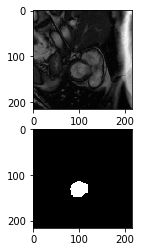

In [23]:
cine_dataset.which_mask = 'endo'
sample = cine_dataset[120]

print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
print(np.max(sample[0]))

im = np.transpose(sample[0], [1, 2, 0])
m = np.transpose(sample[1], [1, 2, 0])
ss = utils.cmr_ml_utils_plotting.plot_image_array(np.concatenate((im, m), axis=2), columns=1, figsize=[4, 4])

(1, 216, 216)
(1, 216, 216)
295/I_13_00_0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead


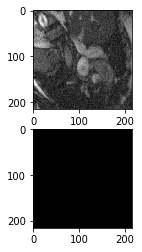

In [24]:
cine_dataset.which_mask = 'epi'
sample = cine_dataset[120]

print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
print(np.max(sample[0]))

im = np.transpose(sample[0], [1, 2, 0])
m = np.transpose(sample[1], [1, 2, 0])
ss = utils.cmr_ml_utils_plotting.plot_image_array(np.concatenate((im, m), axis=2), columns=1, figsize=[4, 4])

## Check to see if data loaded properly

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead


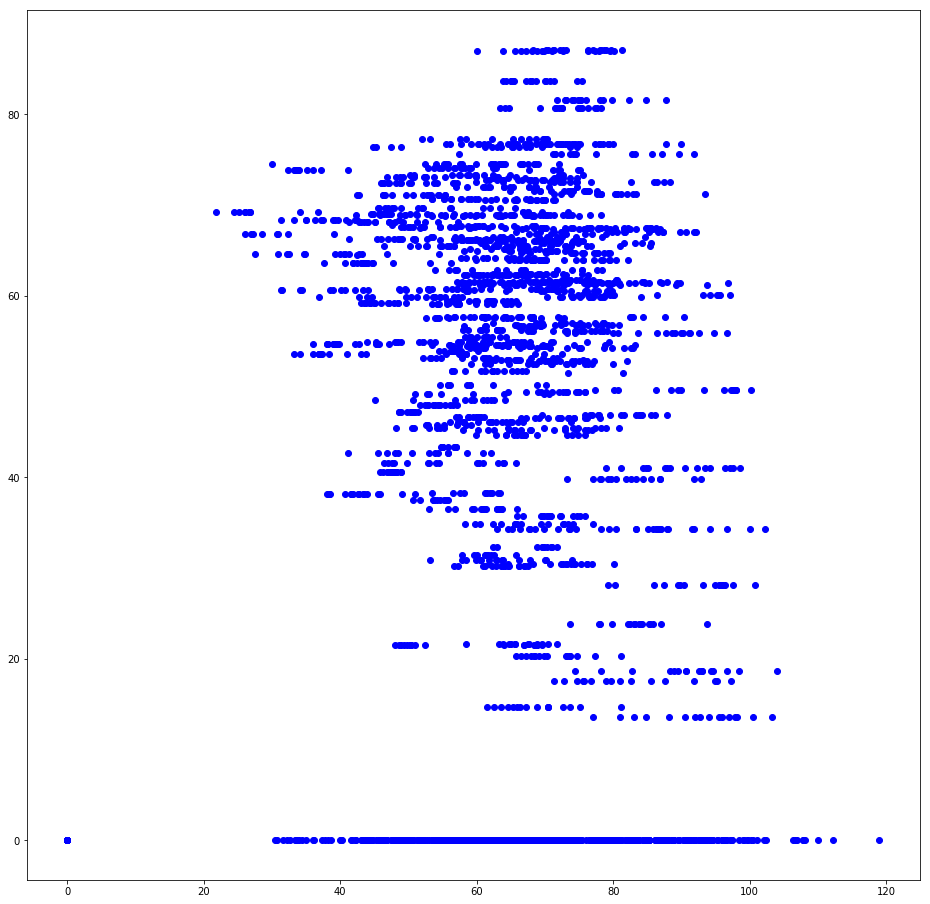

In [25]:
B = len(cine_dataset)

ni = np.zeros(B)
nm = np.zeros(B)

for n in np.arange(B):
    if(n>3000):
        break;
    images, masks, names = cine_dataset[n]
    ni[n] = np.linalg.norm(images)
    nm[n] = np.linalg.norm(masks)

plt.figure(figsize=(16,16))    
plt.plot(ni, nm, 'bo')

In [28]:
print(cine_dataset)

NUM_TRAIN = len(cine_dataset)-40
print('NUM_TRAIN is ', NUM_TRAIN)
batch_size = 16

loader_for_train_test = DataLoader(cine_dataset, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_for_val_test = DataLoader(cine_dataset, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cine_dataset))))

Cine Dataset
  image root: /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set1_ready
  image root: /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set2_ready
  mask: epi
  Number of samples: 393795
  Number of endo masks: 393795
  endo image shape: 1 216 216
  endo mask shape: 1 216 216
  Number of image for epi samples: 196937
  Number of epi masks: 196937
  epi image shape: 1 216 216
  epi mask shape: 1 216 216

NUM_TRAIN is  196897


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 1, 216, 216])
torch.Size([16, 1, 216, 216])
('544/I_00_00_6', '168/I_07_00_13', '84/I_06_00_9', '283/I_04_00_9', '214/I_09_00_0', '237/I_04_00_0', '96/I_00_00_7', '365/I_02_00_12', '156/I_05_00_8', '448/I_05_00_3', '47/I_02_00_0', '303/I_09_00_8', '477/I_07_00_13', '74/I_09_00_15', '284/I_04_00_6', '187/I_00_00_6')
(3, 220, 3490)
(3, 220, 3490)


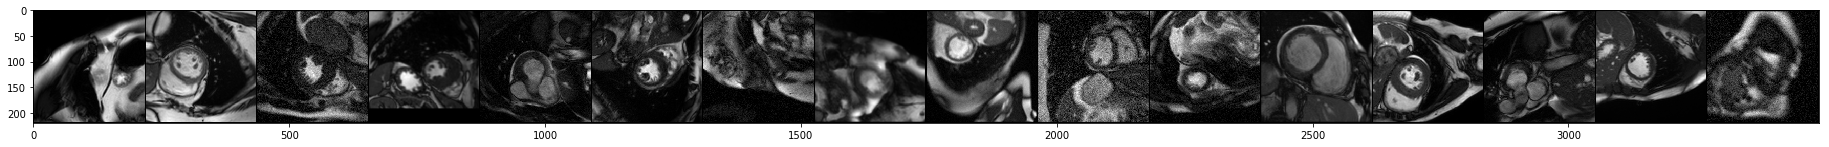

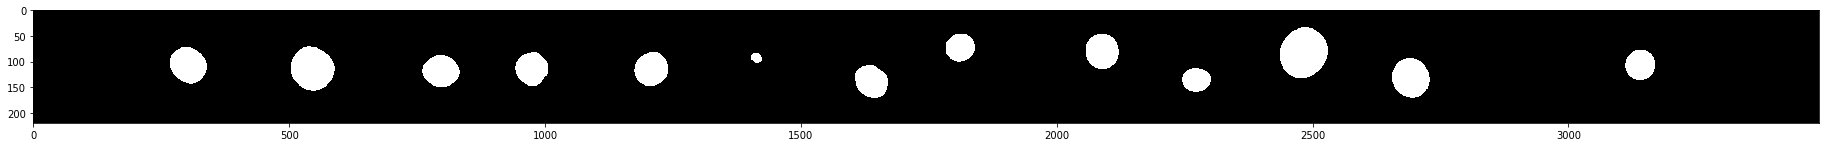

In [29]:
iter_train = iter(loader_for_train_test)
print(iter_train)
images, masks, names = iter_train.next()

print(images.shape)
print(masks.shape)
print(names)
   
plt.figure(figsize=(32,32))
show(make_grid(images.float(), nrow=batch_size, padding=2, normalize=False, scale_each=True))

plt.figure(figsize=(32,32))
show(make_grid(masks.float(), nrow=batch_size, padding=2, normalize=False, scale_each=True))

## Detect GPU

In [30]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")

using device: cuda
Let's use 4 GPUs!


## Train network

In [34]:
transform=torchvision.transforms.Compose([ RandomFlip1stDim(0.5), RandomFlip2ndDim(0.5), RandomPermute2DT(0.5), RandomBlurring(p=0.5, sigma=[0.5, 0.75, 1.0, 1.5]), RandomAddNoise(p=0.5, sigma=[0.05, 0.1, 0.15, 0.2, 0.3]) ])

In [16]:
num_of_random = 16

cine_dataset = CineDatasetRandomCrop([img_dir, img_dir2], num_of_random=num_of_random, which_mask='endo', data_size=(216, 216))
print("Done")

Found 13594 cases in all folders ... 

=============> Start loading cases for  /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set1_ready <==============================
--------------------------> Start loading  295  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_15_00', 'I_05_00']
------> Start loading 0 out of 14490, 295 - I_04_01
    image size [320, 260], ro, [start, end] = 52, 268; e1, [start, end] = 22, 238
             Time from starting : 0.175640 seconds ... 

--------------------------> Start loading  662  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_

             Time from starting : 2.812700 seconds ... 

--------------------------> Start loading  118  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 410 out of 14490, 118 - I_04_01
    image size [370, 301], ro, [start, end] = 77, 293; e1, [start, end] = 42, 258
             Time from starting : 2.994196 seconds ... 

--------------------------> Start loading  516  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 436 out of 14490, 516 - 

--------------------------> Start loading  164  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 804 out of 14490, 164 - I_04_01
    image size [420, 354], ro, [start, end] = 102, 318; e1, [start, end] = 69, 285
             Time from starting : 5.859567 seconds ... 

--------------------------> Start loading  177  <--------------------------
['I_04_01', 'I_00_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_03_01', 'I_00_01', 'I_02_01', 'I_01_00', 'I_04_00', 'I_03_00', 'I_05_00']
------> Start loading 826 out of 14490, 177 - I_04_01
    image size [380, 333], ro, [start, end] = 82, 298; e1, [start, end] = 58, 274
             Time from starting : 5.945908 seconds ... 

--------------------------> Start loading  464  <--------------------------
['I_04_01

             Time from starting : 8.333713 seconds ... 

--------------------------> Start loading  479  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1200 out of 14490, 479 - I_04_01
    image size [340, 340], ro, [start, end] = 62, 278; e1, [start, end] = 62, 278
             Time from starting : 8.486634 seconds ... 

--------------------------> Start loading  276  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1222 out of 14490, 276 - I_04_01
    image size [420, 315], ro, [start, end] = 102, 318; 

             Time from starting : 11.630124 seconds ... 

--------------------------> Start loading  582  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1610 out of 14490, 582 - I_04_01
    image size [360, 326], ro, [start, end] = 72, 288; e1, [start, end] = 55, 271
             Time from starting : 11.770224 seconds ... 

--------------------------> Start loading  669  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1630 out of 14490, 669 - I_04_01
    image size [360, 293], ro, [start, end] = 72, 288; e1, [start, end] = 38, 254
             Tim

             Time from starting : 14.980948 seconds ... 

--------------------------> Start loading  396  <--------------------------
['I_17_00', 'I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_17_01', 'I_11_01', 'I_16_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_16_00', 'I_15_00', 'I_05_00']
------> Start loading 2008 out of 14490, 396 - I_17_00
    image size [380, 309], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 15.234869 seconds ... 

--------------------------> Start loading  427  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01',

             Time from starting : 18.967963 seconds ... 

--------------------------> Start loading  82  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2404 out of 14490, 82 - I_04_01
    image size [360, 270], ro, [start, end] = 72, 288; e1, [start, end] = 27, 243
             Time from starting : 19.115595 seconds ... 

--------------------------> Start loading  560  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2428 out of 14490, 560 - I_04_01
    image size [225, 400], ro, [start, end] = 4, 220; e1, [start, end] = 92, 3

             Time from starting : 22.160670 seconds ... 

--------------------------> Start loading  129  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_16_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_16_00', 'I_15_00', 'I_05_00']
------> Start loading 2800 out of 14490, 129 - I_04_01
    image size [430, 349], ro, [start, end] = 107, 323; e1, [start, end] = 66, 282
             Time from starting : 22.411777 seconds ... 

--------------------------> Start loading  89  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01',

             Time from starting : 24.937478 seconds ... 

--------------------------> Start loading  571  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3188 out of 14490, 571 - I_04_01
    image size [380, 261], ro, [start, end] = 82, 298; e1, [start, end] = 22, 238
             Time from starting : 25.045812 seconds ... 

--------------------------> Start loading  483  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3208 out of 14490, 483 - I_04_01
    image size [330, 330], ro, [start, end] = 57, 273;

             Time from starting : 27.831590 seconds ... 

--------------------------> Start loading  434  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3612 out of 14490, 434 - I_04_01
    image size [340, 340], ro, [start, end] = 62, 278; e1, [start, end] = 62, 278
             Time from starting : 28.002282 seconds ... 

--------------------------> Start loading  232  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading

             Time from starting : 30.502145 seconds ... 

--------------------------> Start loading  668  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3988 out of 14490, 668 - I_04_01
    image size [340, 276], ro, [start, end] = 62, 278; e1, [start, end] = 30, 246
             Time from starting : 30.618076 seconds ... 

--------------------------> Start loading  92  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4006 out of 14490, 92 - I_04_01
    image size [360, 281], ro, [start, end] = 72, 288; e1, [start, end] = 32, 248
             Time 

             Time from starting : 34.269628 seconds ... 

--------------------------> Start loading  418  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4370 out of 14490, 418 - I_04_01
    image size [420, 420], ro, [start, end] = 102, 318; e1, [start, end] = 102, 318
             Time from starting : 34.451926 seconds ... 

--------------------------> Start loading  423  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4394 out of 14490, 423 - I_04_01
    image size [360, 360], ro, [start, end] = 72, 28

             Time from starting : 37.471763 seconds ... 

--------------------------> Start loading  363  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4788 out of 14490, 363 - I_04_01
    image size [440, 330], ro, [start, end] = 112, 328; e1, [start, end] = 57, 273
             Time from starting : 37.632549 seconds ... 

--------------------------> Start loading  355  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4810 out of 14490, 355 - I_04_01
    image size [450, 450], ro, 

             Time from starting : 40.032607 seconds ... 

--------------------------> Start loading  601  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5168 out of 14490, 601 - I_04_01
    image size [320, 250], ro, [start, end] = 52, 268; e1, [start, end] = 17, 233
             Time from starting : 40.139322 seconds ... 

--------------------------> Start loading  103  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5190 out of 14490, 103 - I_04_01
    image 

             Time from starting : 43.082876 seconds ... 

--------------------------> Start loading  489  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5538 out of 14490, 489 - I_04_01
    image size [400, 400], ro, [start, end] = 92, 308; e1, [start, end] = 92, 308
             Time from starting : 43.263084 seconds ... 

--------------------------> Start loading  148  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01',

             Time from starting : 45.675133 seconds ... 

--------------------------> Start loading  377  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_16_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_16_00', 'I_15_00', 'I_05_00']
------> Start loading 5926 out of 14490, 377 - I_04_01
    image size [280, 320], ro, [start, end] = 32, 248; e1, [start, end] = 52, 268
             Time from starting : 45.891094 seconds ... 

--------------------------> Start loading  414  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']

             Time from starting : 48.574919 seconds ... 

--------------------------> Start loading  548  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6312 out of 14490, 548 - I_04_01
    image size [360, 360], ro, [start, end] = 72, 288; e1, [start, end] = 72, 288
             Time from starting : 48.748688 seconds ... 

--------------------------> Start loading  73  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6336 out of 14490, 73 - I_04_01
    image size [240, 320], ro, [start, end] = 12, 228; e

             Time from starting : 50.938431 seconds ... 

--------------------------> Start loading  345  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6684 out of 14490, 345 - I_04_01
    image size [380, 261], ro, [start, end] = 82, 298; e1, [start, end] = 22, 238
             Time from starting : 51.051454 seconds ... 

--------------------------> Start loading  640  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6704 out of 14490, 640 - I_04_01
    image size [400, 275], ro, [start, end] = 92, 308; e1, [start, end] = 30

             Time from starting : 53.584609 seconds ... 

--------------------------> Start loading  226  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7072 out of 14490, 226 - I_04_01
    image size [400, 250], ro, [start, end] = 92, 308; e1, [start, end] = 17, 233
             Time from starting : 53.681510 seconds ... 

--------------------------> Start loading  149  <--------------------------
['I_17_00', 'I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_18_01', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_17_01', 'I_11_01', 'I_16_01', 'I_18_00', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00',

             Time from starting : 56.276664 seconds ... 

--------------------------> Start loading  444  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7474 out of 14490, 444 - I_04_01
    image size [400, 400], ro, [start, end] = 92, 308; e1, [start, end] = 92, 308
             Time from starting : 56.455882 seconds ... 

--------------------------> Start loading  456  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7498 out of 14490, 456 - I_04_01
    image 

             Time from starting : 58.787453 seconds ... 

--------------------------> Start loading  4  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7864 out of 14490, 4 - I_04_01
    image size [380, 321], ro, [start, end] = 82, 298; e1, [start, end] = 52, 268
             Time from starting : 58.957204 seconds ... 

--------------------------> Start loading  74  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7888 out of 14490, 74 - I_04_01
    image size [350, 263], ro, [start, end] = 67, 283; e1, [

             Time from starting : 61.303988 seconds ... 

--------------------------> Start loading  344  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8240 out of 14490, 344 - I_04_01
    image size [360, 248], ro, [start, end] = 72, 288; e1, [start, end] = 16, 232
             Time from starting : 61.410087 seconds ... 

--------------------------> Start loading  411  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8262 out of 14490, 411 - I_04_01
    image size [340, 340], ro, [

             Time from starting : 64.387040 seconds ... 

--------------------------> Start loading  350  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8634 out of 14490, 350 - I_04_01
    image size [320, 290], ro, [start, end] = 52, 268; e1, [start, end] = 37, 253
             Time from starting : 64.551748 seconds ... 

--------------------------> Start loading  240  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8658 out of 14490, 240 - I_04_01
    image size [360, 293], ro, [start, end] = 72, 288;

             Time from starting : 67.446831 seconds ... 

--------------------------> Start loading  642  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9008 out of 14490, 642 - I_04_01
    image size [360, 293], ro, [start, end] = 72, 288; e1, [start, end] = 38, 254
             Time from starting : 67.630002 seconds ... 

--------------------------> Start loading  536  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9034 out of 14490, 53

             Time from starting : 70.672042 seconds ... 

--------------------------> Start loading  69  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9390 out of 14490, 69 - I_04_01
    image size [360, 270], ro, [start, end] = 72, 288; e1, [start, end] = 27, 243
             Time from starting : 70.807449 seconds ... 

--------------------------> Start loading  561  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9412 out of 14490, 561 

             Time from starting : 73.848371 seconds ... 

--------------------------> Start loading  239  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9770 out of 14490, 239 - I_04_01
    image size [360, 293], ro, [start, end] = 72, 288; e1, [start, end] = 38, 254
             Time from starting : 74.014717 seconds ... 

--------------------------> Start loading  214  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9794 out of 14490, 214 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 308; e1, [start, end] = 54

             Time from starting : 76.550013 seconds ... 

--------------------------> Start loading  650  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10154 out of 14490, 650 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 76.728152 seconds ... 

--------------------------> Start loading  77  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10178 out of 14490, 77 - I_04_01
    image size [263, 350], ro, [

             Time from starting : 79.255254 seconds ... 

--------------------------> Start loading  514  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10552 out of 14490, 514 - I_04_01
    image size [420, 420], ro, [start, end] = 102, 318; e1, [start, end] = 102, 318
             Time from starting : 79.443352 seconds ... 

--------------------------> Start loading  447  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10576 out of 14490, 447 - I_04_01
    im

             Time from starting : 82.018348 seconds ... 

--------------------------> Start loading  397  <--------------------------
['I_17_00', 'I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_14_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_17_01', 'I_11_01', 'I_16_01', 'I_11_00', 'I_12_00', 'I_15_01', 'I_13_01', 'I_07_01', 'I_14_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_16_00', 'I_15_00', 'I_05_00']
------> Start loading 10950 out of 14490, 397 - I_17_00
    image size [340, 329], ro, [start, end] = 62, 278; e1, [start, end] = 56, 272
             Time from starting : 82.276734 seconds ... 

--------------------------> Start loading  512  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01'

             Time from starting : 84.859710 seconds ... 

--------------------------> Start loading  279  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11350 out of 14490, 279 - I_04_01
    image size [380, 309], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 85.001693 seconds ... 

--------------------------> Start loading  563  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11370 out of 14490, 563 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 30

             Time from starting : 87.614288 seconds ... 

--------------------------> Start loading  0  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11774 out of 14490, 0 - I_04_01
    image size [380, 321], ro, [start, end] = 82, 298; e1, [start, end] = 52, 268
             Time from starting : 87.785966 seconds ... 

--------------------------> Start loading  268  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11798 out of 14490, 268 - I_04_01
    image size [360, 293], ro, [start, end] = 72, 288; e

             Time from starting : 90.794575 seconds ... 

--------------------------> Start loading  505  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12158 out of 14490, 505 - I_04_01
    image size [380, 380], ro, [start, end] = 82, 298; e1, [start, end] = 82, 298
             Time from starting : 90.969479 seconds ... 

--------------------------> Start loading  629  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12182 out of 14490, 629 - I_04_01
    image size [370, 254], ro, [start, end] = 77, 29

             Time from starting : 93.363231 seconds ... 

--------------------------> Start loading  170  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12536 out of 14490, 170 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 93.506973 seconds ... 

--------------------------> Start loading  80  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12556 out of 14490, 80 - I_04_01
    image size [440, 330], ro, [start, end] = 112, 328; e1, [start, end] = 5

             Time from starting : 95.636777 seconds ... 

--------------------------> Start loading  37  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12890 out of 14490, 37 - I_04_01
    image size [340, 234], ro, [start, end] = 62, 278; e1, [start, end] = 9, 225
             Time from starting : 95.735023 seconds ... 

--------------------------> Start loading  358  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12914 out of 14490, 358 - I_04_01
    image s

             Time from starting : 98.097332 seconds ... 

--------------------------> Start loading  179  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13272 out of 14490, 179 - I_04_01
    image size [360, 315], ro, [start, end] = 72, 288; e1, [start, end] = 50, 266
             Time from starting : 98.238502 seconds ... 

--------------------------> Start loading  70  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13292 out of 14490, 70 - I_04_01
    image size [320, 240], ro, [start, end] = 52, 268; e1, [start, end] = 12, 228
             Time from starting : 98.3

             Time from starting : 100.523221 seconds ... 

--------------------------> Start loading  424  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13640 out of 14490, 424 - I_04_01
    image size [400, 400], ro, [start, end] = 92, 308; e1, [start, end] = 92, 308
             Time from starting : 100.732810 seconds ... 

--------------------------> Start loading  125  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13668 out of 14490

             Time from starting : 103.243413 seconds ... 

--------------------------> Start loading  310  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 14044 out of 14490, 310 - I_04_01
    image size [197, 300], ro, [start, end] = 0, 216; e1, [start, end] = 42, 258
             Time from starting : 103.290349 seconds ... 

--------------------------> Start loading  199  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 14066 out of 14490, 199 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 308; e1, [start, end] =

             Time from starting : 105.774451 seconds ... 

--------------------------> Start loading  202  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 14444 out of 14490, 202 - I_04_01
    image size [380, 309], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 105.916812 seconds ... 

--------------------------> Start loading  455  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 14464 out of 14490, 455 - I_04_01
    image size [400, 400], r

             Time from starting : 2.325697 seconds ... 

--------------------------> Start loading  486  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 352 out of 13594, 486 - I_04_01
    image size [291, 360], ro, [start, end] = 38, 254; e1, [start, end] = 72, 288
             Time from starting : 2.482203 seconds ... 

--------------------------> Start loading  118  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 374 out of 13594, 118 - I_04_01
    image size [255, 340], ro, [star

             Time from starting : 4.917864 seconds ... 

--------------------------> Start loading  637  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 738 out of 13594, 637 - I_04_01
    image size [380, 380], ro, [start, end] = 82, 298; e1, [start, end] = 82, 298
             Time from starting : 5.107928 seconds ... 

--------------------------> Start loading  164  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 764 out of 13594, 164 - 

             Time from starting : 7.380947 seconds ... 

--------------------------> Start loading  166  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1122 out of 13594, 166 - I_04_01
    image size [450, 363], ro, [start, end] = 117, 333; e1, [start, end] = 74, 290
             Time from starting : 7.559639 seconds ... 

--------------------------> Start loading  152  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1146 out of 13594, 152 - I_04_01
    image s

             Time from starting : 10.257299 seconds ... 

--------------------------> Start loading  582  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1534 out of 13594, 582 - I_04_01
    image size [380, 380], ro, [start, end] = 82, 298; e1, [start, end] = 82, 298
             Time from starting : 10.420497 seconds ... 

--------------------------> Start loading  523  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1556 out of 13594, 523 - I_04_01
    image size [350, 263], ro, [start, end] = 67, 283;

             Time from starting : 12.778373 seconds ... 

--------------------------> Start loading  720  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1910 out of 13594, 720 - I_04_01
    image size [350, 263], ro, [start, end] = 67, 283; e1, [start, end] = 24, 240
             Time from starting : 12.902628 seconds ... 

--------------------------> Start loading  173  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 1932 out of 13594, 17

             Time from starting : 15.244436 seconds ... 

--------------------------> Start loading  570  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2268 out of 13594, 570 - I_04_01
    image size [450, 338], ro, [start, end] = 117, 333; e1, [start, end] = 61, 277
             Time from starting : 15.425104 seconds ... 

--------------------------> Start loading  207  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2292 out of 13594, 207 - I_04_01
    image size [350, 263], ro, 

             Time from starting : 17.607998 seconds ... 

--------------------------> Start loading  281  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2618 out of 13594, 281 - I_04_01
    image size [400, 327], ro, [start, end] = 92, 308; e1, [start, end] = 56, 272
             Time from starting : 17.798972 seconds ... 

--------------------------> Start loading  357  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 2642 out of 13594, 357 - I_04_01
    image size [388, 388], ro, [start, end] = 86, 302;

             Time from starting : 20.562855 seconds ... 

--------------------------> Start loading  504  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3008 out of 13594, 504 - I_04_01
    image size [240, 320], ro, [start, end] = 12, 228; e1, [start, end] = 52, 268
             Time from starting : 20.654536 seconds ... 

--------------------------> Start loading  163  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3028 out of 13594, 163 - I_04_01
    image size [360, 291], ro, [start, end] = 72, 288;

             Time from starting : 23.221224 seconds ... 

--------------------------> Start loading  292  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3376 out of 13594, 292 - I_04_01
    image size [400, 323], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 23.397047 seconds ... 

--------------------------> Start loading  356  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3398 out of 13594, 356 - I_04_01
    image size [375, 375], ro, [

             Time from starting : 25.970009 seconds ... 

--------------------------> Start loading  482  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3770 out of 13594, 482 - I_04_01
    image size [440, 355], ro, [start, end] = 112, 328; e1, [start, end] = 70, 286
             Time from starting : 26.135526 seconds ... 

--------------------------> Start loading  165  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 3790 out of 13594, 165 - I_04_01
    image size [400, 323], ro, [start, end] = 92, 308

             Time from starting : 28.954143 seconds ... 

--------------------------> Start loading  568  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4162 out of 13594, 568 - I_04_01
    image size [380, 285], ro, [start, end] = 82, 298; e1, [start, end] = 34, 250
             Time from starting : 29.124296 seconds ... 

--------------------------> Start loading  625  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4184 out of 13594, 625 - I_04_01
    image size [360, 360], ro, [

             Time from starting : 31.455928 seconds ... 

--------------------------> Start loading  569  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4528 out of 13594, 569 - I_04_01
    image size [315, 420], ro, [start, end] = 50, 266; e1, [start, end] = 102, 318
             Time from starting : 31.632436 seconds ... 

--------------------------> Start loading  11  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4550 out of 13594, 11 - I_04_01
    image size [340, 255], ro, [start, end] = 62, 278; e1, [start, end] = 20, 236
             Time

             Time from starting : 33.920605 seconds ... 

--------------------------> Start loading  50  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4886 out of 13594, 50 - I_04_01
    image size [340, 255], ro, [start, end] = 62, 278; e1, [start, end] = 20, 236
             Time from starting : 34.019830 seconds ... 

--------------------------> Start loading  537  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 4904 out of 13594, 537 - I_04_01
    image size [300, 400], ro, [start, end] = 42, 258; e1, [start, end] = 92, 

             Time from starting : 36.677344 seconds ... 

--------------------------> Start loading  452  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5280 out of 13594, 452 - I_04_01
    image size [360, 294], ro, [start, end] = 72, 288; e1, [start, end] = 39, 255
             Time from starting : 36.859844 seconds ... 

--------------------------> Start loading  338  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5304 out of 13594, 338 - I_04_01
    image 

             Time from starting : 39.401865 seconds ... 

--------------------------> Start loading  595  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5656 out of 13594, 595 - I_04_01
    image size [400, 400], ro, [start, end] = 92, 308; e1, [start, end] = 92, 308
             Time from starting : 39.614853 seconds ... 

--------------------------> Start loading  725  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 5682 out of 13594, 72

             Time from starting : 41.973861 seconds ... 

--------------------------> Start loading  153  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6016 out of 13594, 153 - I_04_01
    image size [400, 323], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 42.162983 seconds ... 

--------------------------> Start loading  605  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6040 out of 13594, 605 - I_04_01
    image 

             Time from starting : 44.790141 seconds ... 

--------------------------> Start loading  219  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6396 out of 13594, 219 - I_04_01
    image size [400, 300], ro, [start, end] = 92, 308; e1, [start, end] = 42, 258
             Time from starting : 44.961770 seconds ... 

--------------------------> Start loading  201  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6418 out of 13594, 201 - I_04_01
    image size [370, 278], ro, [start, end] = 77, 293;

             Time from starting : 47.528934 seconds ... 

--------------------------> Start loading  481  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6764 out of 13594, 481 - I_04_01
    image size [340, 275], ro, [start, end] = 62, 278; e1, [start, end] = 30, 246
             Time from starting : 47.682855 seconds ... 

--------------------------> Start loading  280  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 6786 out of 13594, 280 - I_04_01
    image size [360, 291], ro, [start, end] = 72, 288; e1, [start, end] = 38

             Time from starting : 50.340127 seconds ... 

--------------------------> Start loading  272  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7154 out of 13594, 272 - I_04_01
    image size [307, 380], ro, [start, end] = 46, 262; e1, [start, end] = 82, 298
             Time from starting : 50.510788 seconds ... 

--------------------------> Start loading  461  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7176 out of 13594, 461 - I_04_01
    image size [354, 354], ro, [start, end] = 69, 285; e1, [start, end] = 69

             Time from starting : 53.070766 seconds ... 

--------------------------> Start loading  291  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7548 out of 13594, 291 - I_04_01
    image size [400, 323], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 53.243924 seconds ... 

--------------------------> Start loading  630  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7570 out of 13594, 63

             Time from starting : 55.816568 seconds ... 

--------------------------> Start loading  102  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7972 out of 13594, 102 - I_04_01
    image size [370, 278], ro, [start, end] = 77, 293; e1, [start, end] = 31, 247
             Time from starting : 55.965481 seconds ... 

--------------------------> Start loading  608  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 7994 out of 13594, 608 - I_04_01
    image 

             Time from starting : 58.830275 seconds ... 

--------------------------> Start loading  604  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8380 out of 13594, 604 - I_04_01
    image size [380, 380], ro, [start, end] = 82, 298; e1, [start, end] = 82, 298
             Time from starting : 59.021443 seconds ... 

--------------------------> Start loading  167  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8404 out of 13594, 167 - I_04_01
    image size [300, 225], ro, [start, end] = 42, 258;

             Time from starting : 61.279188 seconds ... 

--------------------------> Start loading  218  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8732 out of 13594, 218 - I_04_01
    image size [330, 248], ro, [start, end] = 57, 273; e1, [start, end] = 16, 232
             Time from starting : 61.377727 seconds ... 

--------------------------> Start loading  656  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 8752 out of 13594, 656 - I_04_01
    image size [360, 360], ro, [start, end] = 72, 288;

             Time from starting : 63.916729 seconds ... 

--------------------------> Start loading  171  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9116 out of 13594, 171 - I_04_01
    image size [420, 339], ro, [start, end] = 102, 318; e1, [start, end] = 62, 278
             Time from starting : 64.076126 seconds ... 

--------------------------> Start loading  2  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9136 out of 13594, 2 - I_04_01
    image size [380, 285], ro, [start, end] = 82, 298; e1

    image size [360, 270], ro, [start, end] = 72, 288; e1, [start, end] = 27, 243
             Time from starting : 66.593144 seconds ... 

--------------------------> Start loading  353  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9482 out of 13594, 353 - I_04_01
    image size [321, 321], ro, [start, end] = 52, 268; e1, [start, end] = 52, 268
             Time from starting : 66.745100 seconds ... 

--------------------------> Start loading  552  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9502 out of 13594, 552 - I_

             Time from starting : 69.254556 seconds ... 

--------------------------> Start loading  176  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9862 out of 13594, 176 - I_04_01
    image size [380, 307], ro, [start, end] = 82, 298; e1, [start, end] = 46, 262
             Time from starting : 69.440505 seconds ... 

--------------------------> Start loading  387  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 9886 out of 13594, 387 - I_04_01
    image 

             Time from starting : 72.235039 seconds ... 

--------------------------> Start loading  5  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10250 out of 13594, 5 - I_04_01
    image size [255, 340], ro, [start, end] = 20, 236; e1, [start, end] = 62, 278
             Time from starting : 72.361534 seconds ... 

--------------------------> Start loading  241  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10274 out of 13594, 241 - I_04_01
    image size [380, 285], ro, [st

             Time from starting : 74.922217 seconds ... 

--------------------------> Start loading  376  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10636 out of 13594, 376 - I_04_01
    image size [450, 338], ro, [start, end] = 117, 333; e1, [start, end] = 61, 277
             Time from starting : 75.096016 seconds ... 

--------------------------> Start loading  633  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 10656 out of 13594, 633 - I_04_01
    image size [380, 380], ro

             Time from starting : 77.281435 seconds ... 

--------------------------> Start loading  390  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11018 out of 13594, 390 - I_04_01
    image size [400, 325], ro, [start, end] = 92, 308; e1, [start, end] = 54, 270
             Time from starting : 77.438549 seconds ... 

--------------------------> Start loading  0  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11038 out of 13594, 0 - I_04_01
    image size [300, 225], ro, [start, end] = 42, 258; e1, [start, end] = 4, 220
             Time f

             Time from starting : 79.982646 seconds ... 

--------------------------> Start loading  54  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11388 out of 13594, 54 - I_04_01
    image size [270, 360], ro, [start, end] = 27, 243; e1, [start, end] = 72, 288
             Time from starting : 80.114570 seconds ... 

--------------------------> Start loading  45  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11408 out of 13594, 45 - I_04_01
    image size [400, 300], ro, [start, end] = 92, 308; e1, [start, end] = 42, 258
             Time 

             Time from starting : 82.550885 seconds ... 

--------------------------> Start loading  170  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_12_01', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_12_00', 'I_13_01', 'I_07_01', 'I_04_00', 'I_13_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11744 out of 13594, 170 - I_04_01
    image size [450, 363], ro, [start, end] = 117, 333; e1, [start, end] = 74, 290
             Time from starting : 82.779475 seconds ... 

--------------------------> Start loading  80  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 11772 out of 13594, 

             Time from starting : 85.183633 seconds ... 

--------------------------> Start loading  37  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12102 out of 13594, 37 - I_04_01
    image size [300, 225], ro, [start, end] = 42, 258; e1, [start, end] = 4, 220
             Time from starting : 85.253282 seconds ... 

--------------------------> Start loading  358  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12122 out of 13594, 358 - I_04_01
    image size [360, 294], ro, [start, end] = 72, 288; e1, [start, end] = 39, 255
             Time

             Time from starting : 87.470439 seconds ... 

--------------------------> Start loading  215  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12460 out of 13594, 215 - I_04_01
    image size [353, 470], ro, [start, end] = 68, 284; e1, [start, end] = 127, 343
             Time from starting : 87.669019 seconds ... 

--------------------------> Start loading  113  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_01_01', 'I_08_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12484 out of 13594, 113 - I_04_01
    image size [390, 293], ro, [start, end] = 87, 303; e1, [start, end] =

             Time from starting : 90.151585 seconds ... 

--------------------------> Start loading  319  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12846 out of 13594, 319 - I_04_01
    image size [375, 375], ro, [start, end] = 80, 296; e1, [start, end] = 80, 296
             Time from starting : 90.342788 seconds ... 

--------------------------> Start loading  403  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 12870 out of 13594, 403 - I_04_01
    image size [380, 309], ro,

             Time from starting : 93.067752 seconds ... 

--------------------------> Start loading  57  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13226 out of 13594, 57 - I_04_01
    image size [263, 350], ro, [start, end] = 24, 240; e1, [start, end] = 67, 283
             Time from starting : 93.212472 seconds ... 

--------------------------> Start loading  287  <--------------------------
['I_04_01', 'I_00_00', 'I_06_00', 'I_05_01', 'I_02_00', 'I_10_01', 'I_01_01', 'I_09_00', 'I_08_00', 'I_09_01', 'I_10_00', 'I_03_01', 'I_00_01', 'I_07_00', 'I_02_01', 'I_01_00', 'I_08_01', 'I_11_01', 'I_11_00', 'I_07_01', 'I_04_00', 'I_03_00', 'I_06_01', 'I_05_00']
------> Start loading 13250 out of 13594, 287 - I_04_01
    image 

In [35]:
print(cine_dataset)

Cine Dataset
  image root: /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set1_ready
  image root: /home/xueh2/mrprogs/gadgetron_CMR_ML-source/data/data/set2_ready
  mask: epi
  Number of samples: 393795
  Number of endo masks: 393795
  endo image shape: 1 216 216
  endo mask shape: 1 216 216
  Number of image for epi samples: 196937
  Number of epi masks: 196937
  epi image shape: 1 216 216
  epi mask shape: 1 216 216



In [36]:
cine_dataset.transform = transform

In [37]:
cine_dataset.which_mask = 'endo'
num_classes = 1
class_for_accu = [1]
p_thres = 0.5

In [37]:
cine_dataset.which_mask = 'epi'
num_classes = 1
class_for_accu = [1]
p_thres = 0.5

endo
(1, 216, 216)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 4 + 1) instead


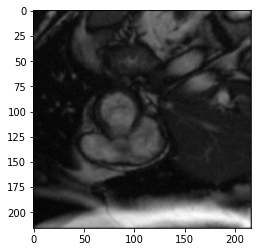

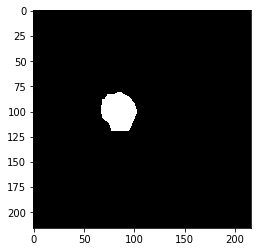

In [39]:

class_weights = None

print(cine_dataset.which_mask)

sample = cine_dataset[120]

print(sample[1].shape)

plt.figure()
plt.imshow(np.squeeze(sample[0]))

plt.figure()
plt.imshow(np.squeeze(sample[1]))

In [40]:
import utils.cmr_ml_utils_data

k = 16

# Chunk into k random sets
chunks = utils.cmr_ml_utils_data.chunk(range(len(cine_dataset)), k)
train_idxs, val_idxs = utils.cmr_ml_utils_data.get_k_fold_training_validation(chunks, val_chunk=0)

num_train = len(train_idxs)
print('num_train = %d' % num_train)
num_val = len(val_idxs)
print('num_val = %d' % num_val)

num_train = 369182
num_val = 24613


In [41]:
batch_size = 80

loader_for_train = DataLoader(cine_dataset, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(train_idxs))

loader_for_val = DataLoader(cine_dataset, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(val_idxs))

print(cine_dataset.which_mask)

endo


torch.Size([80, 1, 216, 216])
torch.Size([80, 1, 216, 216])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 4 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1092, 3490)
(3, 1092, 3490)


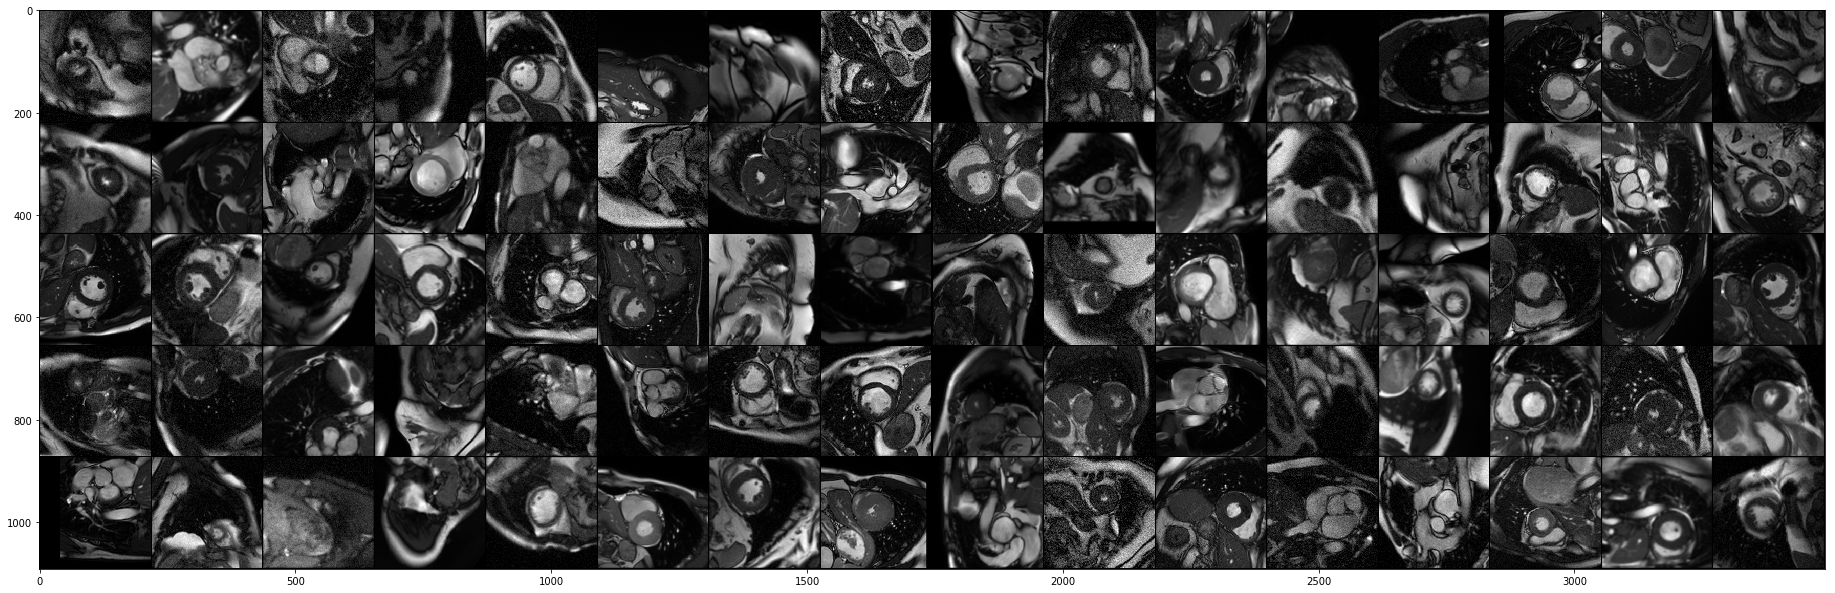

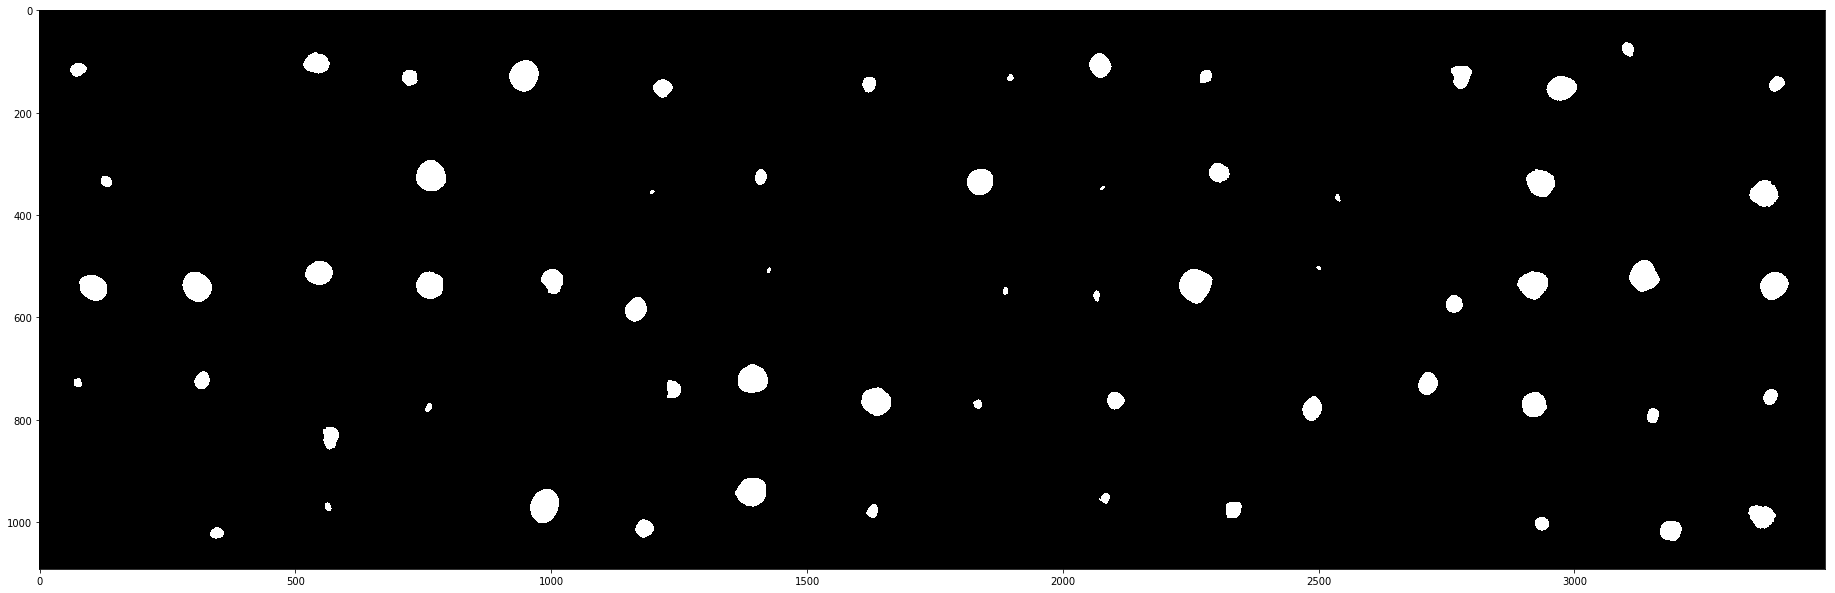

In [42]:
iter_train = iter(loader_for_train)
print(iter_train)
images, masks, names = iter_train.next()

print(images.shape)
print(masks.shape)

plt.figure(figsize=(32,32))
show(make_grid(images.float(), nrow=16, padding=2, normalize=False, scale_each=True))

plt.figure(figsize=(32,32))
show(make_grid(masks.float(), nrow=16, padding=2, normalize=False, scale_each=True))


In [3]:
torch.cuda.empty_cache()

In [4]:
import training
import models
# import hyper_search
# import plot_run

num_epochs = 50
print_every = 100000

inplanes = 96
layers=[4, 4]
layers_planes=[96, 128]

C = 1

model = models.NHLBIResUnet18(F0=C, 
                                  inplanes=inplanes, 
                                  layers=layers, 
                                  layers_planes=layers_planes, 
                                  use_dropout=False, 
                                  p=0.5, 
                                  H=H, W=W, C=1, 
                                  verbose=True)
print(model)


if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print("model on multiple GPU ... ")
    print(model)

p_thres = 0.5
min_prob_allowed = 0.4

patience = 8
factor = 0.5
cooldown = 1
min_lr = 1e-7

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)

weight_decay=0
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), 
                       lr=learning_rate, 
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=weight_decay, 
                       amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                       factor=factor,
                                                       patience=patience, 
                                                       cooldown=cooldown,
                                                       min_lr=min_lr,
                                                       verbose=True)

criterion = training.LossBinary(jaccard_weight=0.5)

log_dir = './cine_training/run/ResUnet' + '_lr_' + str(learning_rate) + '_epochs_' + str(num_epochs)
writer = SummaryWriter(log_dir)

NHLBIResUnet : F0=1, inplanes=96
------------------------------------------------------------
    NHLBIResUnetInputBlock : input size (1, 216, 216), output size (96, 216, 216) --> (96, 216, 216)
------------------------------------------------------------
    NHLBIResUnet, down layer 0:
        NHLBIResUnet, down layer (216, 216) -> (108, 108)
        NHLBIResUnetBasicBlock : input size (96, 108, 108), output size (96, 108, 108) --> (96, 108, 108)
        NHLBIResUnetBasicBlock : input size (96, 108, 108), output size (96, 108, 108) --> (96, 108, 108)
        NHLBIResUnetBasicBlock : input size (96, 108, 108), output size (96, 108, 108) --> (96, 108, 108)
        NHLBIResUnetBasicBlock : input size (96, 108, 108), output size (96, 108, 108) --> (96, 108, 108)
    NHLBIResUnet, down layer 1:
        NHLBIResUnet, down layer (108, 108) -> (54, 54)
        NHLBIResUnetBasicBlock : input size (96, 54, 54), output size (128, 54, 54) --> (128, 54, 54)
        NHLBIResUnetBasicBlock : input s

)


In [45]:
print(device)
print(cine_dataset.which_mask)

perf_trainer = training.NHLBITwoClassSeg_Cine(model, 
                                   optimizer, 
                                   criterion, 
                                   loader_for_train, 
                                   loader_for_val, 
                                   p_thres=p_thres,
                                   min_prob_allowed = min_prob_allowed,
                                   scheduler=scheduler, 
                                   epochs=num_epochs, 
                                   device=device, 
                                   x_dtype=torch.float32, 
                                   y_dtype=torch.float32, 
                                   early_stopping_thres = 10,                              
                                   print_every=print_every, 
                                   small_data_mode=False,
                                   writer=writer, 
                                   model_folder="cine_training/")

cuda
endo


In [ ]:
epochs_traning, epochs_validation, best_model, loss_all, epochs_acc_class = perf_trainer.train(verbose=True, epoch_to_load=-1, save_model_epoch=True)

50
Start training ... 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
----------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 4 + 1) instead


In [ ]:
print(loss_all.shape)

fig = plt.figure()
plt.plot(loss_all[0:1000,0], loss_all[0:1000,1])

In [ ]:
acc, loss, acc_class = perf_trainer.check_validation_test_accuracy(loader_for_val, best_model)
print(acc, loss)
print(acc_class)

In [ ]:
iter_val = iter(loader_for_val)
images, masks, names = iter_val.next()

print(images.shape)
print(masks.shape)

plt.figure(figsize=(32,32))
show(make_grid(images.float(), nrow=12, padding=2, normalize=False, scale_each=True))

plt.figure(figsize=(32,32))
show(make_grid(masks.float(), nrow=12, padding=2, normalize=False, scale_each=True))

N, C, RO, E1 = images.shape

probs = images

best_model.eval()  # set model to evaluation mode
with torch.no_grad():
    for n in range(N):
        
        x = images[n, :,:,:]
        y = masks[n, :,:,:]
        
        x = x / torch.max(x)
        
        x = x.to(device=device, dtype=torch.float32) 
        y = y.to(device=device, dtype=torch.float32)

        scores = best_model(torch.reshape(x, [1, C, RO, E1]))
        
        prob = torch.sigmoid(scores)
        
        probs[n, :,:,:] = prob.cpu()
        
plt.figure(figsize=(32,32))
show(make_grid(probs.float(), nrow=8, padding=2, normalize=False, scale_each=True))

## Saving the model

In [49]:
from datetime import date
today = str(date.today())
print(today)

2019-05-25


In [50]:
model_file = '/home/xueh2/mrprogs/gadgetron_CMR_ML-source/deployment/networks/cine_' + cine_dataset.which_mask + '_network_' + today + '.pbt'
print(model_file)

/home/xueh2/mrprogs/gadgetron_CMR_ML-source/deployment/networks/cine_epi_network_2019-05-25.pbt


In [51]:
print(num_classes)

1


In [ ]:
## Correct save!
import copy 

best_model_wts = copy.deepcopy(best_model_cpu.cpu().state_dict())

empty_model = models.GadgetronResUnet18(F0=C, 
                                  inplanes=inplanes, 
                                  layers=layers, 
                                  layers_planes=layers_planes, 
                                  use_dropout=False, 
                                  p=0.5, 
                                  H=H, W=W, C=num_classes, 
                                  verbose=True)
empty_model.load_state_dict(best_model_wts)

#print(empty_model)

#torch.save(empty_model.state_dict(), '/home/xueh2/cmr_ml/deployment/networks/abstract_network.dict')
torch.save(empty_model, model_file)

In [ ]:
# load test
# work with python application
# Runs on CPU so very slow

model_loaded = torch.load(model_file)

print(model_loaded)